Cell 1：环境与可视化工具（矩阵热力图 + 标注 + 交互）

In [39]:
# ====== Cell 1: imports & visualization helpers ======
import os, math, random, html
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# 中文显示（Windows/常见字体）
plt.rcParams["font.family"] = ["Microsoft YaHei", "SimHei", "SimSun"]
plt.rcParams["axes.unicode_minus"] = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all(42)

# ---------- 矩阵可视化：热力图+数值标注 ----------
def show_matrix(M, row_labels=None, col_labels=None, title="", figsize=(8,4), cmap=None, annotate=True, fmt="{:.2f}"):
    """
    M: torch.Tensor or np.ndarray (2D)
    row_labels/col_labels: list[str]
    """
    if isinstance(M, torch.Tensor):
        M = M.detach().cpu().float().numpy()
    assert M.ndim == 2, f"show_matrix expects 2D, got {M.ndim}"

    plt.figure(figsize=figsize)
    plt.imshow(M, aspect='auto')  # 不指定颜色，让 matplotlib 默认配色
    plt.colorbar()
    plt.title(title)
    if row_labels is not None:
        plt.yticks(range(len(row_labels)), row_labels)
    if col_labels is not None:
        plt.xticks(range(len(col_labels)), col_labels, rotation=45, ha="right")

    if annotate and M.shape[0] <= 30 and M.shape[1] <= 40:
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                plt.text(j, i, fmt.format(M[i, j]), ha="center", va="center", fontsize=8)

    plt.tight_layout()
    plt.show()

def show_vector(v, labels=None, title="", figsize=(8,2)):
    if isinstance(v, torch.Tensor):
        v = v.detach().cpu().float().numpy()
    v = v.reshape(-1)
    plt.figure(figsize=figsize)
    plt.plot(v)
    plt.title(title)
    if labels is not None and len(labels)==len(v):
        plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def show_attention(attn, q_tokens, k_tokens, title="", figsize=(8,4), annotate=True):
    """
    attn: (tq, tk) softmax attention weights
    """
    show_matrix(attn, row_labels=q_tokens, col_labels=k_tokens, title=title, figsize=figsize, annotate=annotate)


DEVICE: cpu


Cell 2：读取数据（用你提供的函数，只取前 60000）

In [3]:
# ====== Cell 2: load WMT zh-en pairs (first 60000) ======
def load_pairs_from_csv_first_comma(path: str | Path, max_rows: int | None = None):
    path = Path(path)
    pairs = []

    with path.open("r", encoding="utf-8") as f:
        for line_idx, line in enumerate(f):
            line = line.strip()
            if not line:
                continue

            # 跳过表头：0,1 或 "0","1"
            if line_idx == 0:
                head = line.replace('"', "").replace(" ", "")
                if head == "0,1":
                    continue

            # 找第一个逗号
            k = line.find(",")
            if k == -1:
                continue

            src = line[:k].strip()
            tgt = line[k+1:].strip()

            # 去两侧引号（若有）
            if len(src) >= 2 and src[0] == '"' and src[-1] == '"':
                src = src[1:-1].strip()
            if len(tgt) >= 2 and tgt[0] == '"' and tgt[-1] == '"':
                tgt = tgt[1:-1].strip()

            # 反转义：&apos; &quot; 等
            src = html.unescape(src)
            tgt = html.unescape(tgt)

            if src and tgt:
                pairs.append((src, tgt))

            if max_rows is not None and len(pairs) >= max_rows:
                break

    return pairs

csv_path = Path(r"wmt_data\wmt_zh_en_training_corpus.csv")
pairs_all = load_pairs_from_csv_first_comma(csv_path, max_rows=60000)
print("Loaded pairs:", len(pairs_all))
for i in range(10):
    print("Example:", pairs_all[i]) 


Loaded pairs: 60000
Example: ('表演 的 明星 是 X 女孩 团队 — — 由 一对 具有 天才 技艺 的 艳舞 女孩 们 组成 ， 其中 有些 人 受过 专业 的 训练 。', 'the show stars the X Girls - a troupe of talented topless dancers , some of whom are classically trained .')
Example: ('表演 的 压轴戏 是 闹剧 版 《 天鹅湖 》 ， 男女 小 人们 身着 粉红色 的 芭蕾舞 裙 扮演 小天鹅 。', 'the centerpiece of the show is a farcical rendition of Swan Lake in which male and female performers dance in pink tutus and imitate swans .')
Example: ('表演 和 后期制作 之间 的 屏障 被 清除 了 ， 这 对 演员 来说 一样 大有裨益 。', 'the removal of the barrier between performance and post @-@ production was just as helpful for the actors .')
Example: ('（ 表演 或 背诵 时 ） 通过 暗示 下面 忘记 或 记地 不准 的 东西 来 帮助 某人 。', 'assist ( somebody acting or reciting ) by suggesting the next words of something forgotten or imperfectly learned .')
Example: ('表演 基本上 很 精彩 - - 我 只 对 她 的 技巧 稍 有 意见 。', 'basically it was a fine performance I have only minor quibbles to make about her technique .')
Example: ('表演 结束 后 ， 我们 看到 一对对 车灯 沿主路 一路 排回 镇上 ， 然后 散开 来 各回 各家 。', "aft

替换 Cell 3：按空格切词 + 统计词表（已分好词版本）

In [6]:
# ====== Cell 3 (REPLACE): whitespace tokenizer for pre-segmented corpus ======
from collections import Counter

SPECIALS = ["[PAD]", "[UNK]", "[BOS]", "[EOS]"]

def tokenize_whitespace(s: str):
    # 你的数据已分词：直接按空格切
    # 顺便去掉空 token
    return [w for w in s.strip().split() if w]

def build_vocab_from_texts(texts, vocab_size=50000, min_freq=1):
    counter = Counter()
    for s in texts:
        counter.update(tokenize_whitespace(s))

    # 过滤低频
    items = [(w,c) for w,c in counter.items() if c >= min_freq]
    items.sort(key=lambda x: x[1], reverse=True)

    # vocab 截断
    itos = SPECIALS + [w for w,_ in items[:max(0, vocab_size - len(SPECIALS))]]
    stoi = {w:i for i,w in enumerate(itos)}
    return stoi, itos, counter

# 用你已经加载的 60000 pairs_all
zh_texts = [s for s,t in pairs_all]
en_texts = [t for s,t in pairs_all]

# 词表大小你可调：越大越接近原语料，越小越快
ZH_VOCAB_SIZE = 50000
EN_VOCAB_SIZE = 40000
MIN_FREQ = 2

zh_stoi, zh_itos, zh_counter = build_vocab_from_texts(zh_texts, vocab_size=ZH_VOCAB_SIZE, min_freq=MIN_FREQ)
en_stoi, en_itos, en_counter = build_vocab_from_texts(en_texts, vocab_size=EN_VOCAB_SIZE, min_freq=MIN_FREQ)

def zh_vocab_id(tok): return zh_stoi.get(tok, zh_stoi["[UNK]"])
def en_vocab_id(tok): return en_stoi.get(tok, en_stoi["[UNK]"])

print("ZH vocab size:", len(zh_stoi), "top10:", zh_counter.most_common(10))
print("EN vocab size:", len(en_stoi), "top10:", en_counter.most_common(10))
# ====== 额外输出：语料真实词汇量 vs 截断后词表大小 ======
zh_unique = len(zh_counter)          # 语料中出现过的中文 token 种类数（真实）
en_unique = len(en_counter)          # 语料中出现过的英文 token 种类数（真实）

print(f"\n[ZH] 语料真实 unique token 数: {zh_unique}")
print(f"[ZH] 设置 vocab_size={ZH_VOCAB_SIZE} 后，实际词表大小(含SPECIALS): {len(zh_stoi)}")
print(f"[ZH] 截断保留比例: {len(zh_stoi) / (zh_unique + len(SPECIALS)):.2%}  (粗略)")

print(f"\n[EN] 语料真实 unique token 数: {en_unique}")
print(f"[EN] 设置 vocab_size={EN_VOCAB_SIZE} 后，实际词表大小(含SPECIALS): {len(en_stoi)}")
print(f"[EN] 截断保留比例: {len(en_stoi) / (en_unique + len(SPECIALS)):.2%}  (粗略)")
zh_dropped = max(0, zh_unique + len(SPECIALS) - len(zh_stoi))
en_dropped = max(0, en_unique + len(SPECIALS) - len(en_stoi))
print(f"\n[ZH] 截断掉的 token 种类数(约): {zh_dropped}")
print(f"[EN] 截断掉的 token 种类数(约): {en_dropped}")

# 检查：真实 unique、freq>=1、freq>=2、freq==1
print("当前 MIN_FREQ =", MIN_FREQ)
print("ZH unique =", len(zh_counter))
print("ZH freq>=1 =", sum(1 for c in zh_counter.values() if c >= 1))
print("ZH freq>=2 =", sum(1 for c in zh_counter.values() if c >= 2))
print("ZH freq==1 =", sum(1 for c in zh_counter.values() if c == 1))

# 检查：词表上限与实际
print("ZH_VOCAB_SIZE =", ZH_VOCAB_SIZE, "SPECIALS =", len(SPECIALS))
print("实际词表 len(zh_stoi) =", len(zh_stoi))
print("len(zh_stoi)-SPECIALS =", len(zh_stoi)-len(SPECIALS))




ZH vocab size: 41335 top10: [('的', 85405), ('，', 78216), ('。', 59252), ('是', 14200), ('在', 13879), ('了', 12592), ('和', 11764), ('、', 7595), ('从', 7549), ('他', 6788)]
EN vocab size: 34434 top10: [('the', 73883), (',', 64554), ('.', 63219), ('of', 39217), ('to', 33312), ('and', 31547), ('a', 30286), ('in', 20508), ('is', 15376), ('that', 10916)]

[ZH] 语料真实 unique token 数: 85463
[ZH] 设置 vocab_size=50000 后，实际词表大小(含SPECIALS): 41335
[ZH] 截断保留比例: 48.36%  (粗略)

[EN] 语料真实 unique token 数: 62691
[EN] 设置 vocab_size=40000 后，实际词表大小(含SPECIALS): 34434
[EN] 截断保留比例: 54.92%  (粗略)

[ZH] 截断掉的 token 种类数(约): 44132
[EN] 截断掉的 token 种类数(约): 28261
当前 MIN_FREQ = 2
ZH unique = 85463
ZH freq>=1 = 85463
ZH freq>=2 = 41331
ZH freq==1 = 44132
ZH_VOCAB_SIZE = 50000 SPECIALS = 4
实际词表 len(zh_stoi) = 41335
len(zh_stoi)-SPECIALS = 41331


Cell 4：把句子变成 Transformer 输入（含 BOS/EOS、padding、mask 可视化）

src_ids: torch.Size([32, 30]) tgt_ids: torch.Size([32, 35])
src_kpm: torch.Size([32, 30]) tgt_kpm: torch.Size([32, 35]) causal: torch.Size([35, 35])


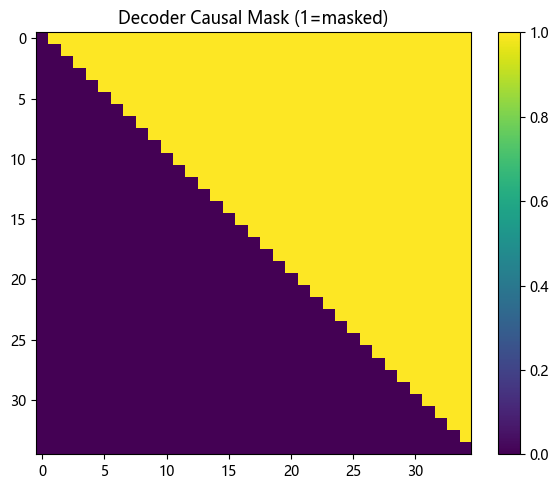


===== Batch 含义 =====
batch_size B = 32  (一次并行处理 32 条句子)
src_ids shape = (32, 30) = (B)
tgt_ids shape = (32, 35)

===== 第 b 条样本（中文）===== 
原始中文文本: 从 外观 上 看 Jake 认为 那 就是 神经 的 接口 ， 通过 它 直接 和 重铠马 的 神经系统 相连 。
src_tokens(截断后): [BOS] 从 外观 上 看 Jake 认为 那 就是 神经 的 接口 ， 通过 它 直接 和 [UNK] 的 神经系统 相连 。 [EOS]

位置 | token | id | src_kpm(是否PAD)
  0 | [BOS]      |      2 | False
  1 | 从          |     12 | False
  2 | 外观         |   2701 | False
  3 | 上          |     25 | False
  4 | 看          |    134 | False
  5 | Jake       |  41034 | False
  6 | 认为         |    117 | False
  7 | 那          |    113 | False
  8 | 就是         |    127 | False
  9 | 神经         |   1714 | False
 10 | 的          |      4 | False
 11 | 接口         |   2387 | False
 12 | ，          |      5 | False
 13 | 通过         |    122 | False
 14 | 它          |     45 | False
 15 | 直接         |    415 | False
 16 | 和          |     10 | False
 17 | [UNK]      |      1 | False
 18 | 的          |      4 | False
 19 | 神经系统       |   7932 |

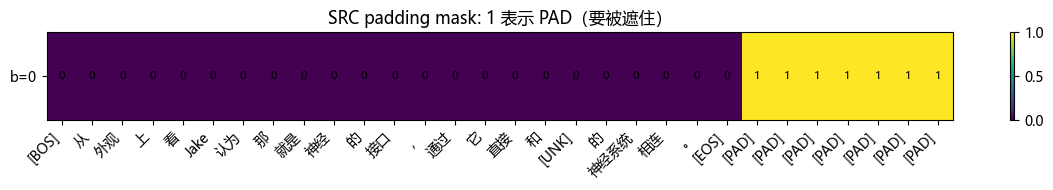

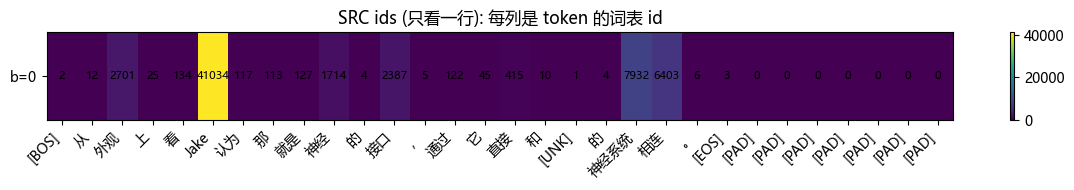

src max len: 30 at index: 28
tgt max len: 35 at index: 15


In [13]:
# ====== Cell 4 (REPLACE PART): numericalize based on whitespace tokens ======
PAD, UNK, BOS, EOS = "[PAD]", "[UNK]", "[BOS]", "[EOS]"
PAD_ID_ZH, BOS_ID_ZH, EOS_ID_ZH = zh_vocab_id(PAD), zh_vocab_id(BOS), zh_vocab_id(EOS)
PAD_ID_EN, BOS_ID_EN, EOS_ID_EN = en_vocab_id(PAD), en_vocab_id(BOS), en_vocab_id(EOS)

def numericalize_zh(s, max_len=64):
    toks = tokenize_whitespace(s)
    ids = [BOS_ID_ZH] + [zh_vocab_id(x) for x in toks][:max_len-2] + [EOS_ID_ZH]
    return ids

def numericalize_en(s, max_len=64):
    toks = tokenize_whitespace(s)
    ids = [BOS_ID_EN] + [en_vocab_id(x) for x in toks][:max_len-2] + [EOS_ID_EN]
    return ids


class WMTDataset(Dataset):
    def __init__(self, pairs, max_len=64):
        self.pairs = pairs
        self.max_len = max_len
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        src_ids = numericalize_zh(src, self.max_len)
        tgt_ids = numericalize_en(tgt, self.max_len)
        return torch.tensor(src_ids, dtype=torch.long), torch.tensor(tgt_ids, dtype=torch.long), src, tgt

def pad_2d(batch_ids, pad_id):
    lengths = [len(x) for x in batch_ids]
    maxlen = max(lengths)
    out = torch.full((len(batch_ids), maxlen), pad_id, dtype=torch.long)
    for i,x in enumerate(batch_ids):
        out[i,:len(x)] = x
    return out, torch.tensor(lengths)

def make_src_key_padding_mask(src_ids, pad_id):
    # True 表示要 mask 掉（padding）
    return (src_ids == pad_id)  # (B, S)

def make_tgt_key_padding_mask(tgt_ids, pad_id):
    return (tgt_ids == pad_id)  # (B, T)

def make_causal_mask(T):
    # True 表示不允许看（上三角）
    return torch.triu(torch.ones(T, T, dtype=torch.bool), diagonal=1)

def collate_fn(batch):
    src_list, tgt_list, src_texts, tgt_texts = zip(*batch)
    src_ids, src_lens = pad_2d(src_list, PAD_ID_ZH)
    tgt_ids, tgt_lens = pad_2d(tgt_list, PAD_ID_EN)

    src_kpm = make_src_key_padding_mask(src_ids, PAD_ID_ZH)   # (B,S)
    tgt_kpm = make_tgt_key_padding_mask(tgt_ids, PAD_ID_EN)   # (B,T)
    causal = make_causal_mask(tgt_ids.size(1))                # (T,T)

    return (src_ids, tgt_ids, src_kpm, tgt_kpm, causal, src_texts, tgt_texts)

# 划分
pairs = pairs_all
random.shuffle(pairs)
train_pairs = pairs[:58000]
val_pairs   = pairs[58000:]

train_ds = WMTDataset(train_pairs, max_len=64)
val_ds   = WMTDataset(val_pairs, max_len=64)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

# 看一个 batch 的 mask
src_ids, tgt_ids, src_kpm, tgt_kpm, causal, src_texts, tgt_texts = next(iter(train_loader))
print("src_ids:", src_ids.shape, "tgt_ids:", tgt_ids.shape)
print("src_kpm:", src_kpm.shape, "tgt_kpm:", tgt_kpm.shape, "causal:", causal.shape)

# 可视化一个样本的 causal mask
show_matrix(causal.float(), title="Decoder Causal Mask (1=masked)", figsize=(6,5), annotate=False)

# ====== 直观查看一个 batch 的内容 ======

def ids_to_tokens(ids_row, itos):
    return [itos[int(i)] for i in ids_row]

def cut_at_eos_or_pad(tokens, eos='[EOS]', pad='[PAD]'):
    # 优先截到 EOS；否则截到 PAD
    if eos in tokens:
        return tokens[:tokens.index(eos)+1]
    if pad in tokens:
        return tokens[:tokens.index(pad)]
    return tokens

b = 0  # 看 batch 中第 0 条样本，你也可以改成 1/2/3...
print("\n===== Batch 含义 =====")
print(f"batch_size B = {src_ids.size(0)}  (一次并行处理 {src_ids.size(0)} 条句子)")
print(f"src_ids shape = {tuple(src_ids.shape)} = (B)")
print(f"tgt_ids shape = {tuple(tgt_ids.shape)}")

# 取出第 b 条样本：中文 ids / mask
src_row = src_ids[b]
src_mask_row = src_kpm[b]  # True=PAD

# 转回 token
src_tokens_full = ids_to_tokens(src_row, zh_itos)
src_tokens_cut  = cut_at_eos_or_pad(src_tokens_full)

print("\n===== 第 b 条样本（中文）===== ")
print("原始中文文本:", src_texts[b])
print("src_tokens(截断后):", " ".join(src_tokens_cut))

# 直观看每个位置：token / id / 是否mask
print("\n位置 | token | id | src_kpm(是否PAD)")
for i, (tok, tid, m) in enumerate(zip(src_tokens_full[:min(30, len(src_tokens_full))],
                                      src_row[:min(30, len(src_row))].tolist(),
                                      src_mask_row[:min(30, len(src_mask_row))].tolist())):
    print(f"{i:>3} | {tok:<10} | {tid:>6} | {str(m)}")

# 把 mask 可视化成 0/1（更直观）
mask01 = src_mask_row.float().unsqueeze(0)  # (1,S)
col_labels = src_tokens_full
# 为了不太挤，最多显示前 40 个 token
max_show = min(40, len(col_labels))
show_matrix(mask01[:, :max_show], 
            row_labels=[f"b={b}"], col_labels=col_labels[:max_show],
            title="SRC padding mask: 1 表示 PAD（要被遮住）", figsize=(12,2), annotate=True, fmt="{:.0f}")

# 再把 src_ids 的前几列也画出来（数值矩阵）
show_matrix(src_ids[b:b+1, :max_show].float(),
            row_labels=[f"b={b}"], col_labels=col_labels[:max_show],
            title="SRC ids (只看一行): 每列是 token 的词表 id", figsize=(12,2), annotate=True, fmt="{:.0f}")

src_lens = (~src_kpm).sum(dim=1)  # 每条中文真实长度（非PAD）
tgt_lens = (~tgt_kpm).sum(dim=1)  # 每条英文真实长度（非PAD）
print("src max len:", src_lens.max().item(), "at index:", src_lens.argmax().item())
print("tgt max len:", tgt_lens.max().item(), "at index:", tgt_lens.argmax().item())


两种常见 padding 策略对比
✅ 动态 padding（你现在的做法，推荐）
每个 batch：pad 到该 batch 最长
优点：padding 少，算得快，省显存
缺点：不同 batch 的张量形状会变（但这没问题）
✅ 全局固定长度 padding（也有人用）
全部样本都 pad/truncate 到一个固定 L（比如 64 或 128）
优点：形状固定（有时便于某些加速/部署）
缺点：大量浪费算力（短句也被 pad 很长）

Cell 5：Embedding（单样本 vs 整个 batch）

B,S_pad = (32, 31)  B,T_pad = (32, 34)
src_vec_batch: (32, 31, 8) tgt_vec_batch: (32, 34, 8)

[单个样本] b=0 true_S = 20
SRC text: 不过 ， 在 我们 周围 汹涌澎湃 的 细菌 海洋 面前 ， 人类 到底 有 多 脆弱 呢 ？
SRC tokens: ['[BOS]', '不过', '，', '在', '我们', '周围', '汹涌澎湃', '的', '细菌', '海洋', '面前', '，', '人类', '到底', '有', '多', '脆弱', '呢', '？', '[EOS]']
src_vec_single shape: (20, 8)


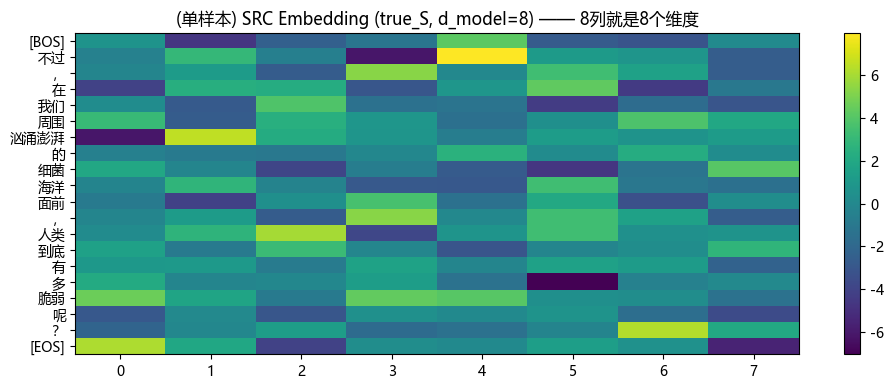

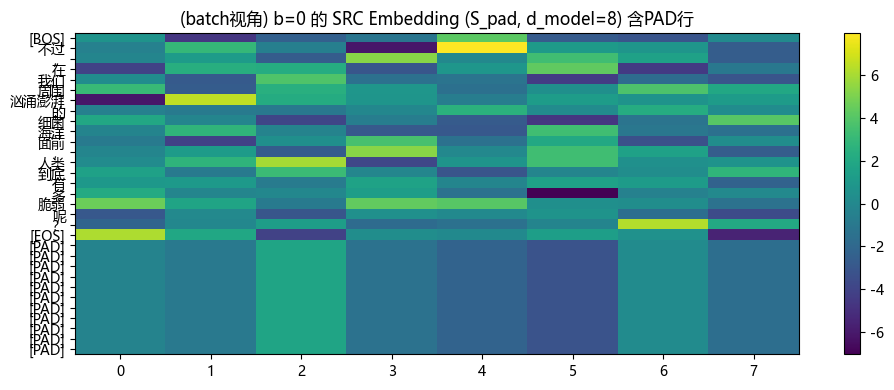

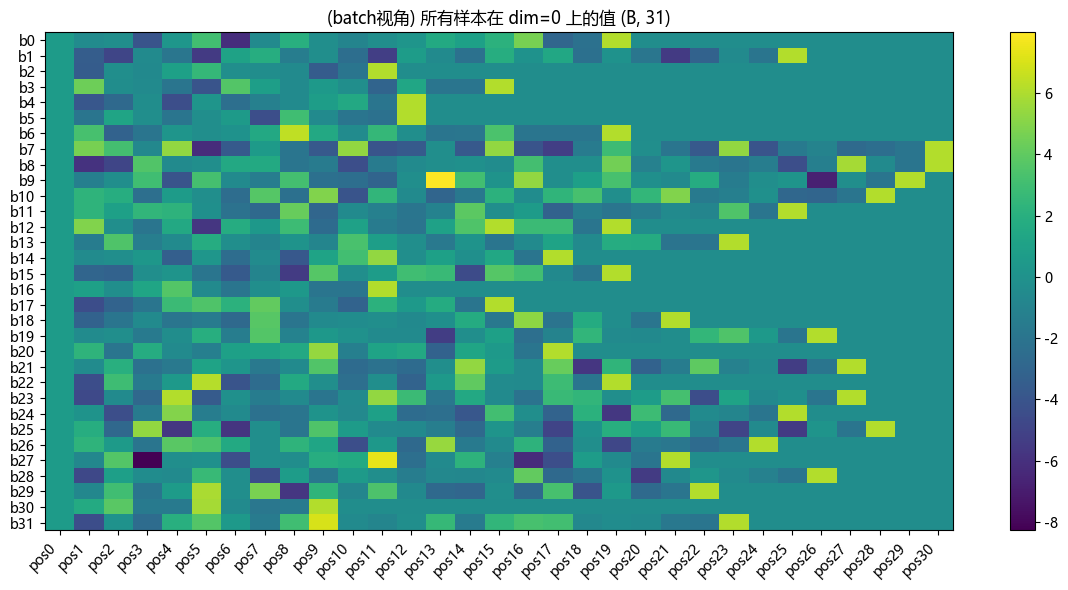

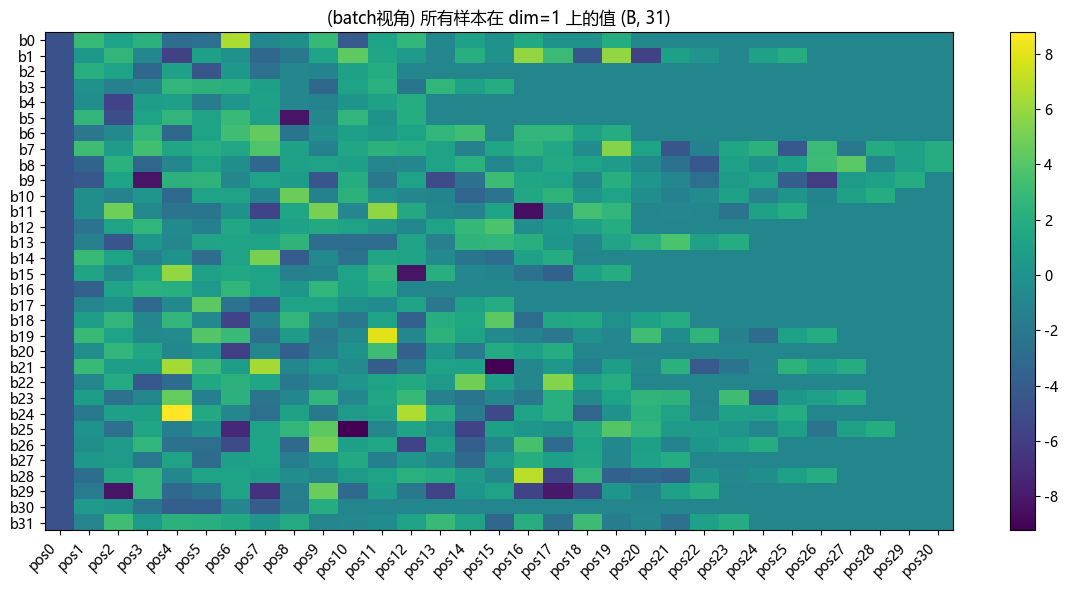

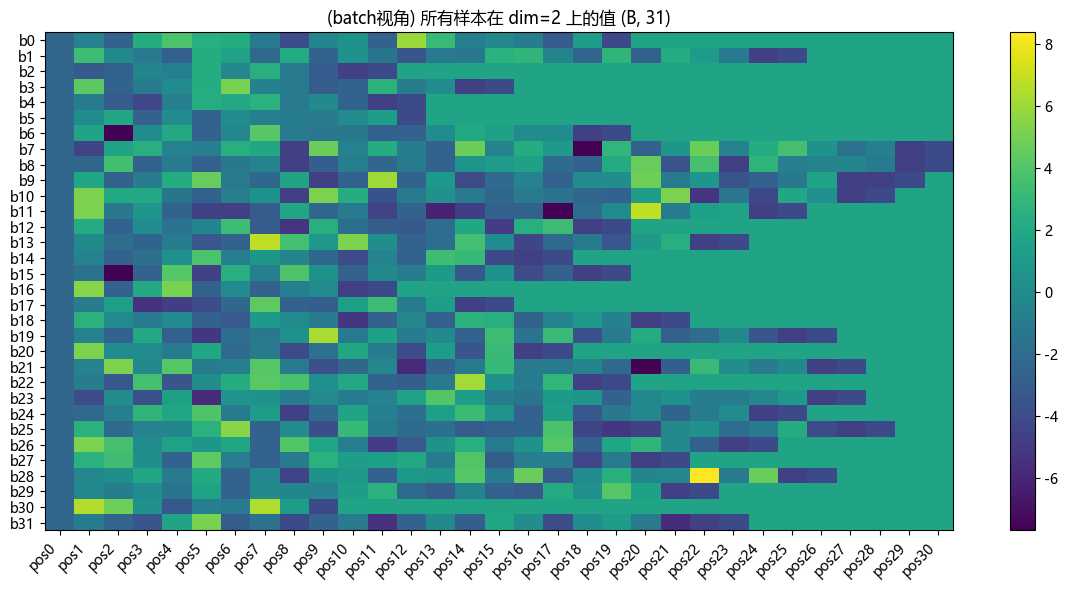

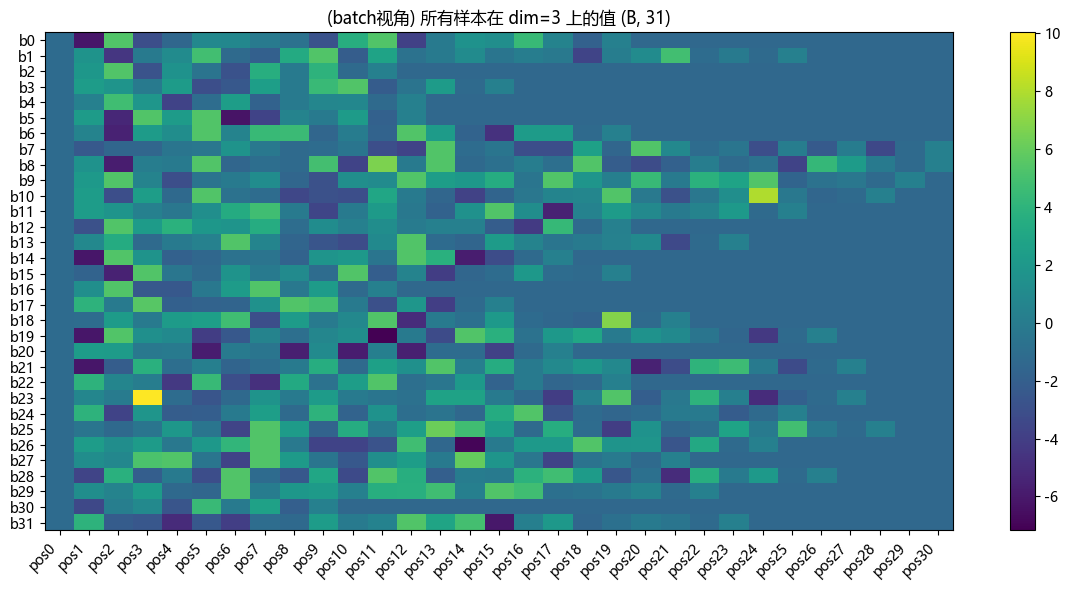

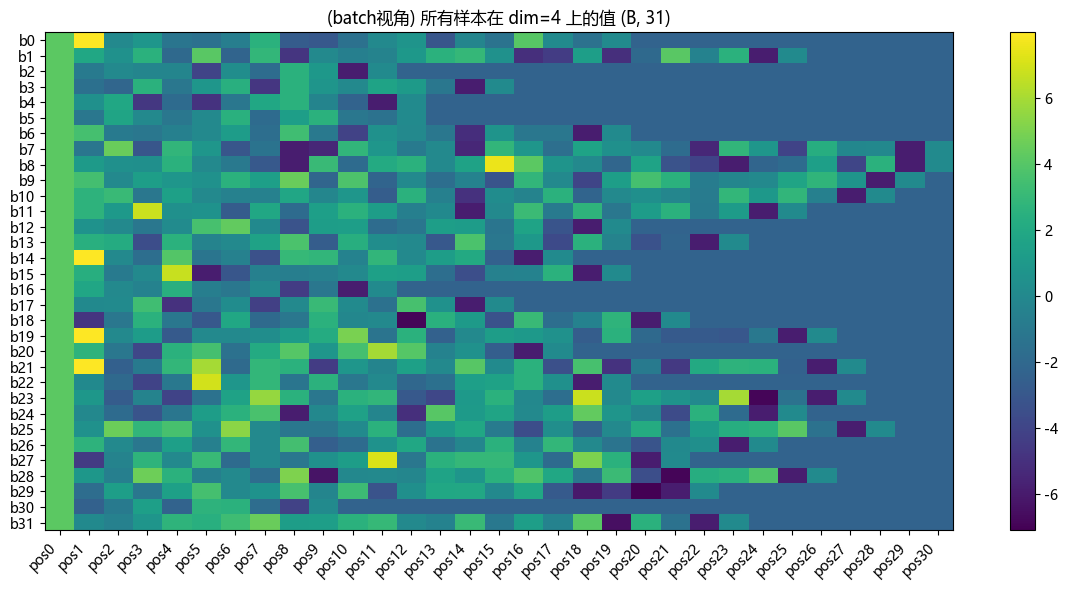

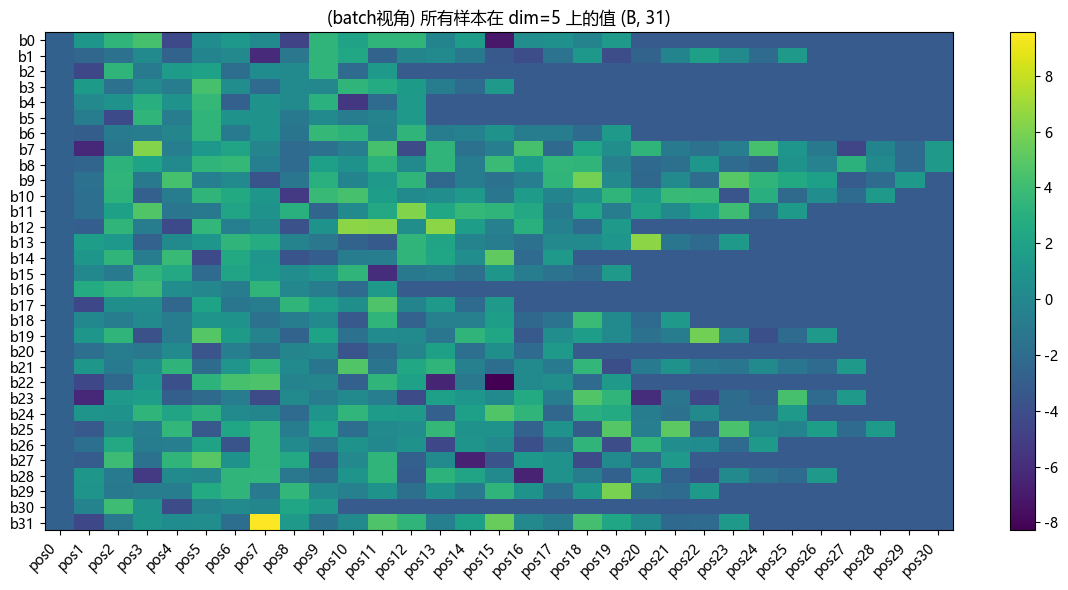

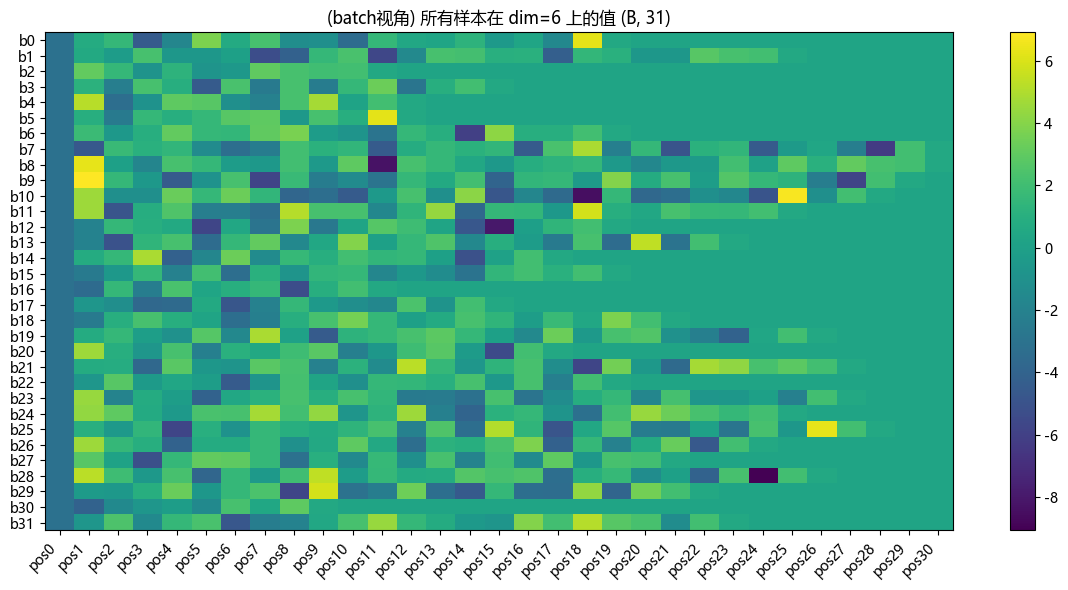

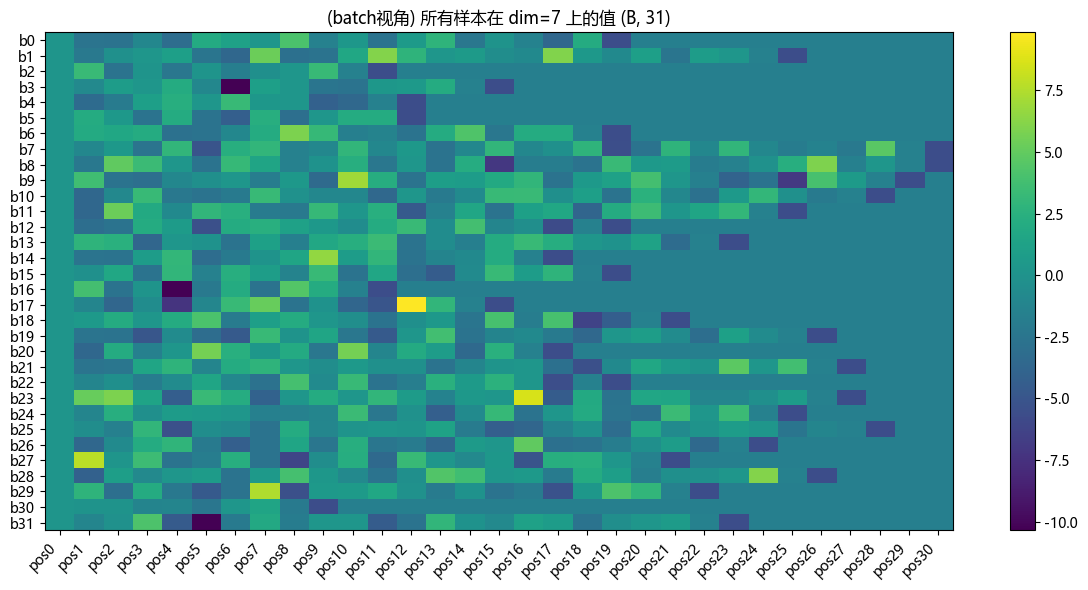

In [22]:
# ====== Cell 5: Embedding (d_model=8, show all 8 dims) ======
import math
import torch
import torch.nn as nn

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
d_model = 8   # ✅ 改成 8

# 取一个 batch（32条）
src_ids, tgt_ids, src_kpm, tgt_kpm, causal, src_texts, tgt_texts = next(iter(train_loader))
B, S_pad = src_ids.shape
B2, T_pad = tgt_ids.shape
print("B,S_pad =", (B, S_pad), " B,T_pad =", (B2, T_pad))

# 建 embedding（先随机初始化，理解形状流程即可）
src_emb = nn.Embedding(len(zh_stoi), d_model).to(DEVICE)
tgt_emb = nn.Embedding(len(en_stoi), d_model).to(DEVICE)

# ====== 1) 整个 batch 的 embedding ======
src_vec_batch = src_emb(src_ids.to(DEVICE)) * math.sqrt(d_model)  # (B,S_pad,D=8)
tgt_vec_batch = tgt_emb(tgt_ids.to(DEVICE)) * math.sqrt(d_model)  # (B,T_pad,D=8)
print("src_vec_batch:", tuple(src_vec_batch.shape), "tgt_vec_batch:", tuple(tgt_vec_batch.shape))

# ====== 2) 单个样本（b=0）从 batch 中切出来 ======
b = 0
src_row = src_ids[b]                  # (S_pad,)
src_mask_row = src_kpm[b]             # (S_pad,) True=PAD
true_S = int((~src_mask_row).sum().item())  # 非PAD长度

src_tokens_full = [zh_itos[int(i)] for i in src_row.tolist()]
src_tokens = src_tokens_full[:true_S]  # 截断到非PAD

src_vec_single = src_vec_batch[b, :true_S]  # (true_S, D=8)

print("\n[单个样本] b=0 true_S =", true_S)
print("SRC text:", src_texts[b])
print("SRC tokens:", src_tokens[:25])
print("src_vec_single shape:", tuple(src_vec_single.shape))

# 可视化：单个样本的 embedding（每列就是一个维度，共8列）
show_matrix(src_vec_single, row_labels=src_tokens,
            title="(单样本) SRC Embedding (true_S, d_model=8) —— 8列就是8个维度",
            figsize=(10,4), annotate=False)

# 可视化：batch 的 embedding（方式A：b=0 含PAD）
show_matrix(src_vec_batch[b].detach().cpu(), row_labels=src_tokens_full,
            title="(batch视角) b=0 的 SRC Embedding (S_pad, d_model=8) 含PAD行",
            figsize=(10,4), annotate=False)

# ====== 方式B：把 8 个维度全部展示（每个 dim 一张 B×S_pad 图）=====
max_col = min(S_pad, 35)  # 避免太宽
for dim in range(d_model):
    mat_BS = src_vec_batch[:, :max_col, dim].detach().cpu()  # (B, max_col)
    show_matrix(
        mat_BS,
        row_labels=[f"b{i}" for i in range(B)],
        col_labels=[f"pos{j}" for j in range(max_col)],
        title=f"(batch视角) 所有样本在 dim={dim} 上的值 (B, {max_col})",
        figsize=(12,6),
        annotate=False
    )


Cell 6：位置编码（单样本 vs 整个 batch）

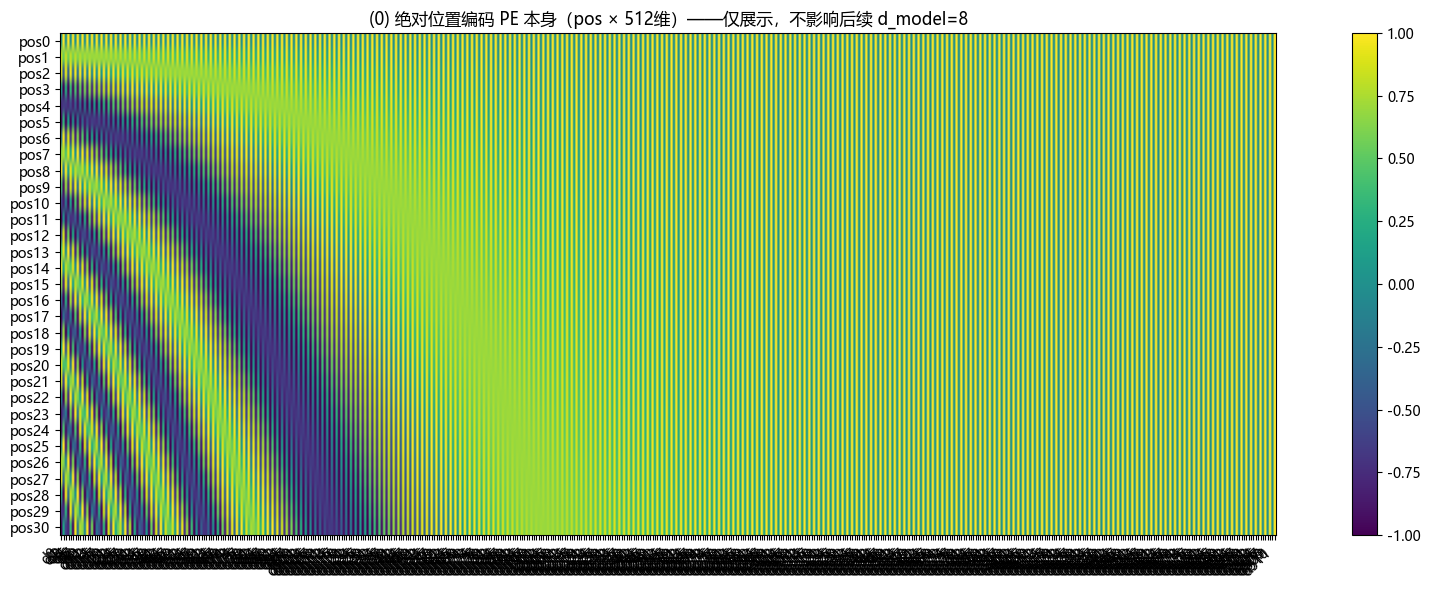

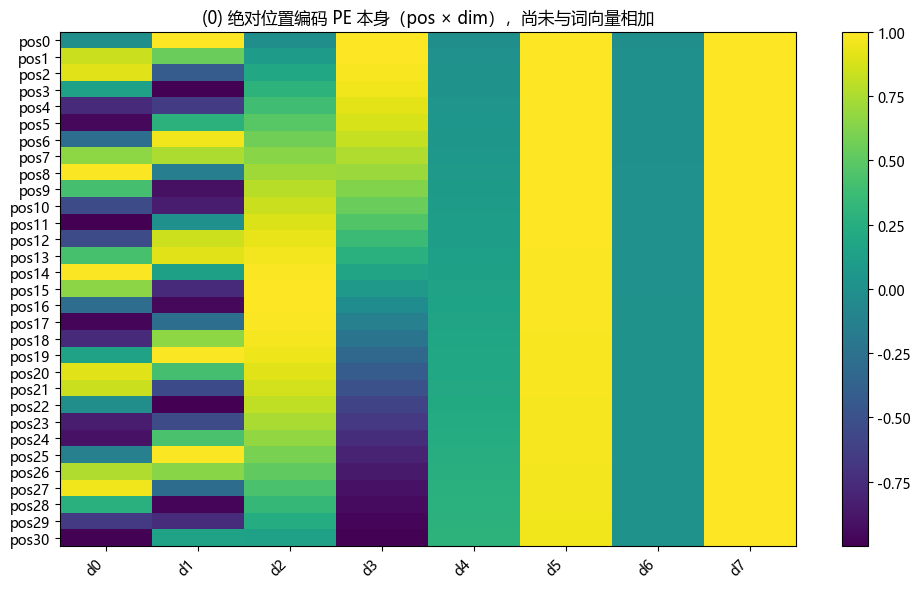

pe_src_batch: (1, 31, 8)
src_after_batch: (32, 31, 8)


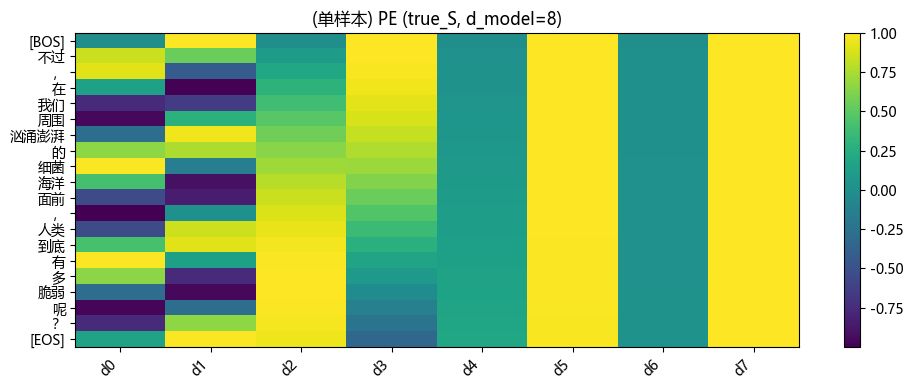

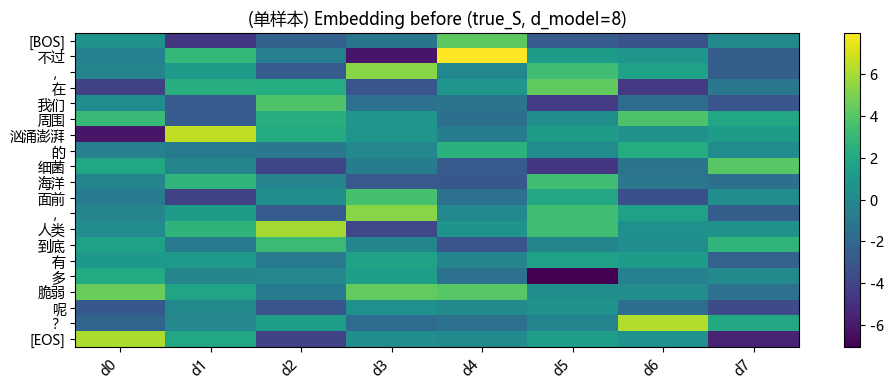

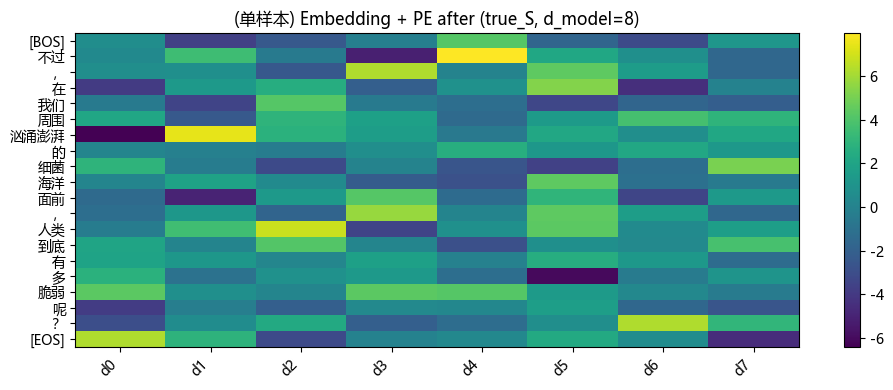

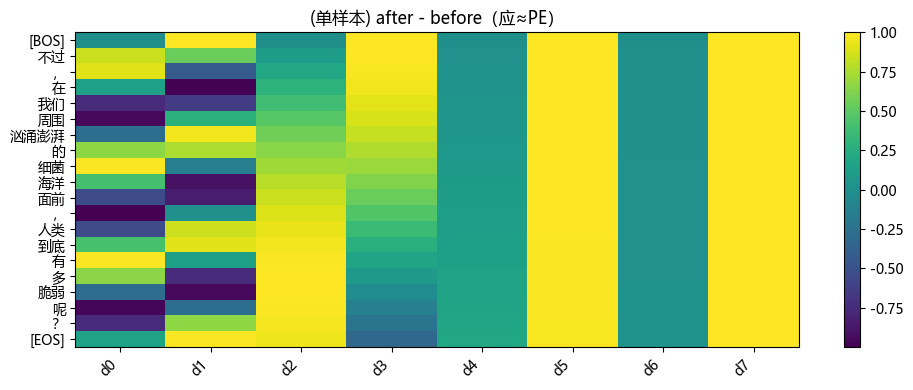

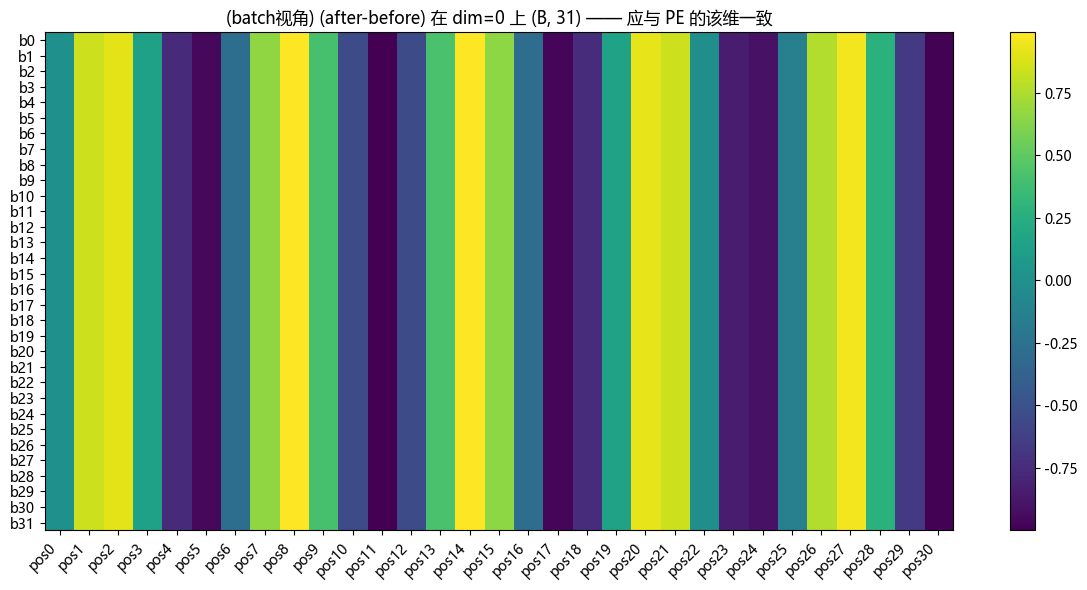

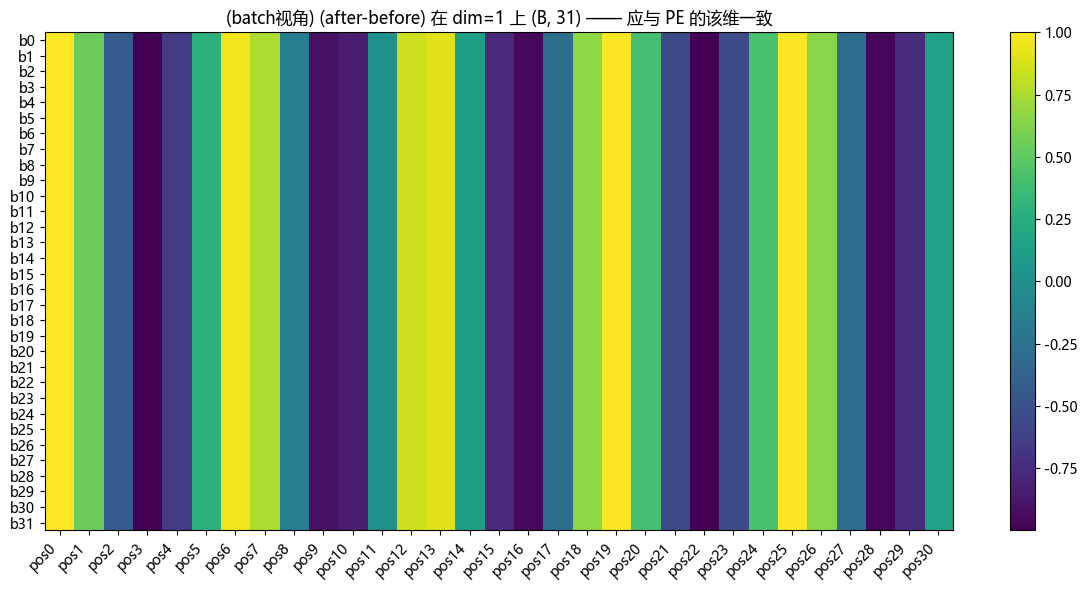

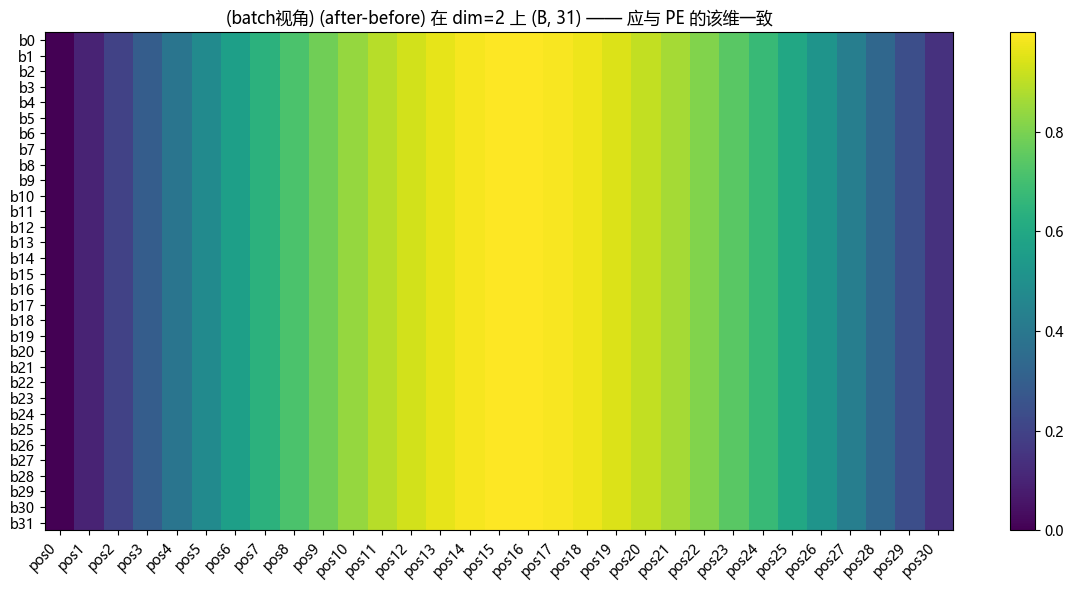

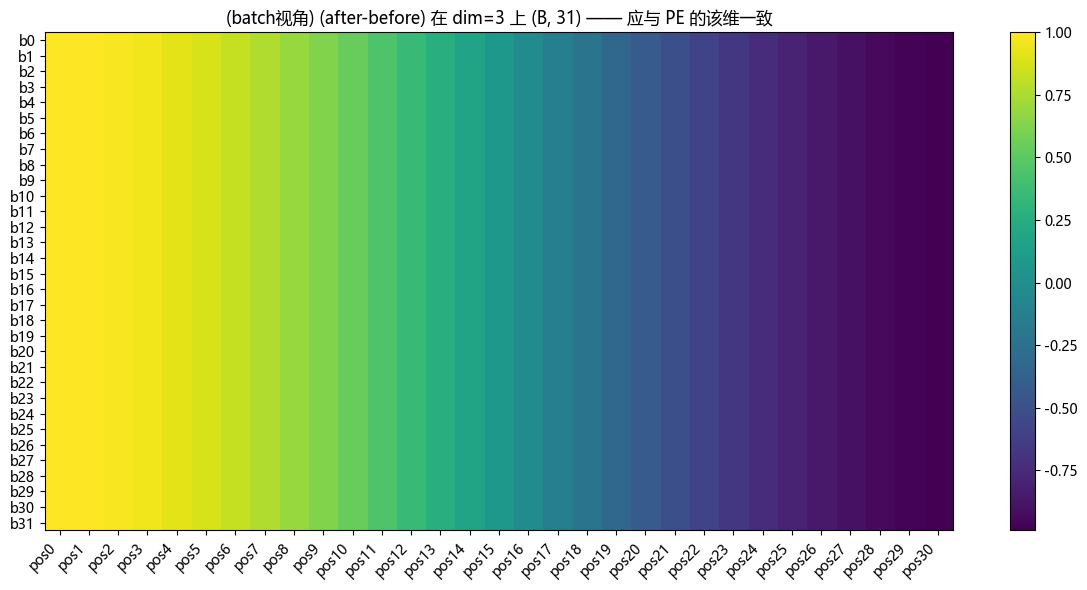

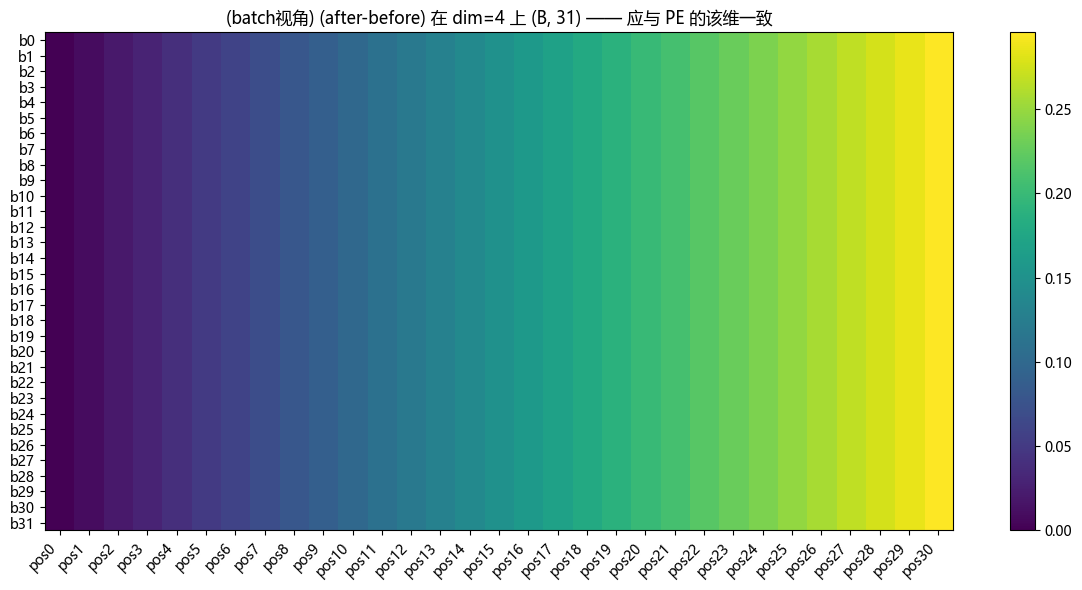

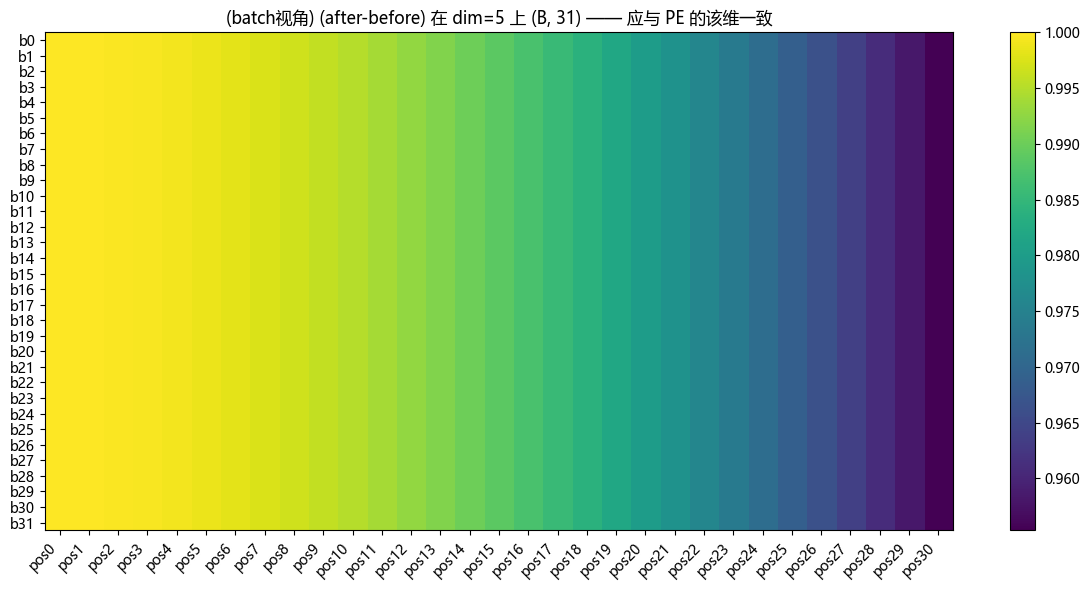

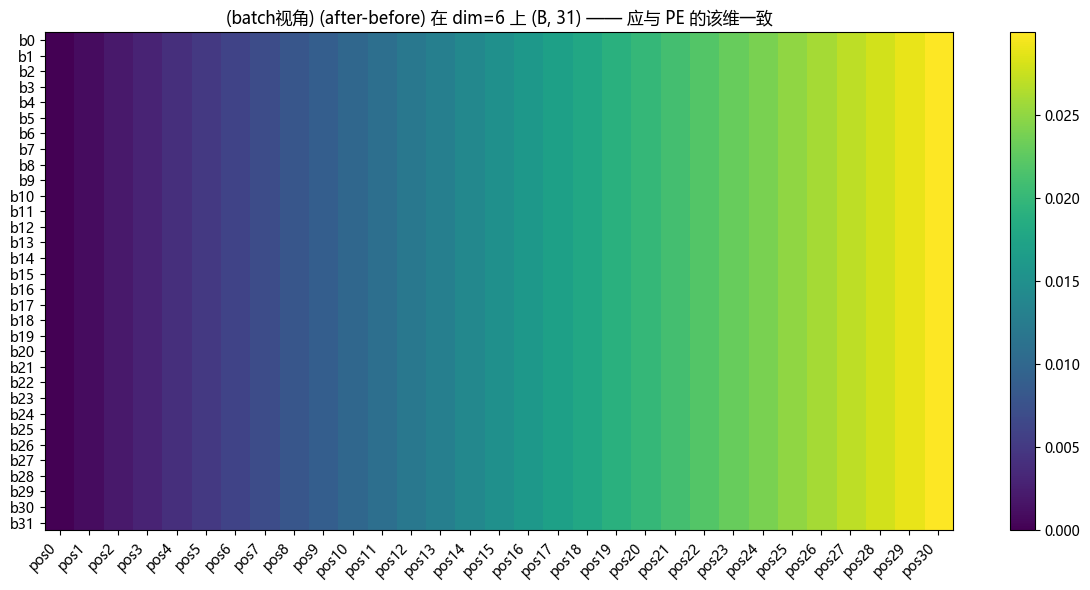

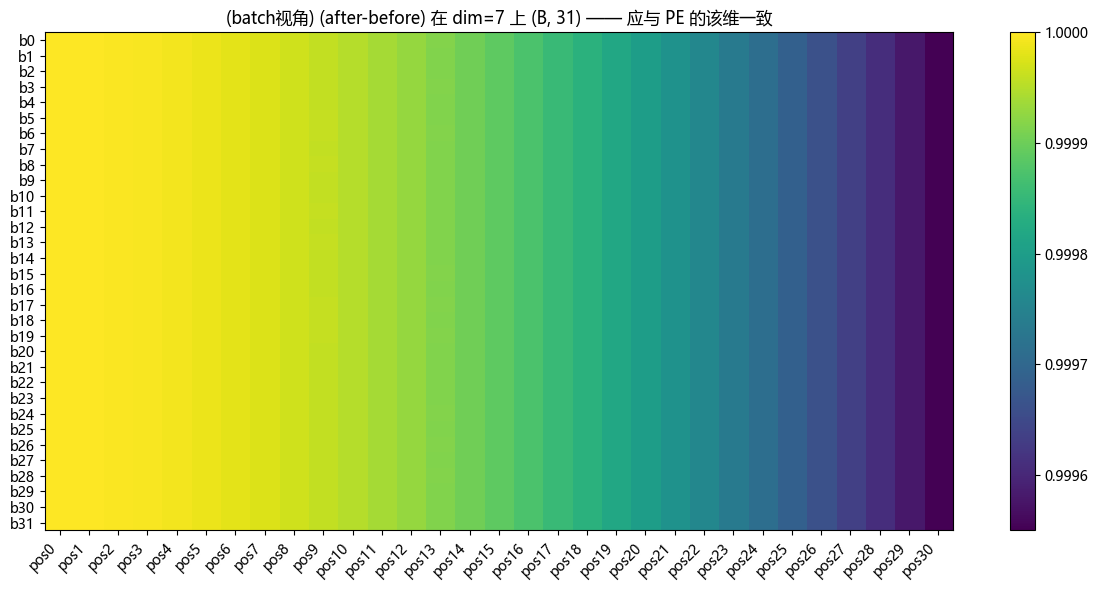

In [25]:
# ====== Cell 6: Positional Encoding —— 先画 PE，再相加（d_model=8）=====
import math
import torch

def sinusoidal_pe(max_len, d_model, device):
    pe = torch.zeros(max_len, d_model, device=device)
    pos = torch.arange(0, max_len, dtype=torch.float, device=device).unsqueeze(1)
    div = torch.exp(torch.arange(0, d_model, 2, device=device).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(pos * div)
    pe[:, 1::2] = torch.cos(pos * div)
    return pe

# ====== 只用于展示：512维绝对位置编码 PE 热力图 ======
d_pe_show = 512
max_pos_show = min(S_pad, 60)  # 512维会很宽，建议pos显示少一些，比如60

pe512 = sinusoidal_pe(max_len=max(S_pad, T_pad), d_model=d_pe_show, device=DEVICE)  # (max_len,512)
pe512_show = pe512[:max_pos_show].detach().cpu()  # (pos,512)

show_matrix(
    pe512_show,
    row_labels=[f"pos{i}" for i in range(max_pos_show)],
    col_labels=[f"d{j}" for j in range(d_pe_show)],
    title="(0) 绝对位置编码 PE 本身（pos × 512维）——仅展示，不影响后续 d_model=8",
    figsize=(16,6),   # 宽一点
    annotate=False
)

# 生成 PE（足够长即可）
pe = sinusoidal_pe(max_len=max(S_pad, T_pad), d_model=d_model, device=DEVICE)  # (max_len, D)

# ====== 0) 先可视化：绝对位置编码 PE 本身（还没加到 embedding）=====
max_pos_show = min(S_pad, 35)   # 只显示前35个位置，避免太大
pe_show = pe[:max_pos_show].detach().cpu()   # (pos, D)

show_matrix(
    pe_show,
    row_labels=[f"pos{i}" for i in range(max_pos_show)],
    col_labels=[f"d{j}" for j in range(d_model)],
    title="(0) 绝对位置编码 PE 本身（pos × dim），尚未与词向量相加",
    figsize=(10,6),
    annotate=False
)

# ====== 1) batch：给每条样本同样加 PE（按位置加）=====
pe_src_batch = pe[:S_pad].unsqueeze(0)                 # (1,S_pad,D)
src_after_batch = src_vec_batch + pe_src_batch         # (B,S_pad,D)

print("pe_src_batch:", tuple(pe_src_batch.shape))
print("src_after_batch:", tuple(src_after_batch.shape))

# ====== 2) 单样本：截断到 true_S（不含PAD）=====
pe_src_single = pe[:true_S]                 # (true_S,D)
src_after_single = src_vec_single + pe_src_single

# 可视化：单样本 PE、before、after、差值
show_matrix(pe_src_single.detach().cpu(), row_labels=src_tokens,
            col_labels=[f"d{j}" for j in range(d_model)],
            title="(单样本) PE (true_S, d_model=8)",
            figsize=(10,4), annotate=False)

show_matrix(src_vec_single.detach().cpu(), row_labels=src_tokens,
            col_labels=[f"d{j}" for j in range(d_model)],
            title="(单样本) Embedding before (true_S, d_model=8)",
            figsize=(10,4), annotate=False)

show_matrix(src_after_single.detach().cpu(), row_labels=src_tokens,
            col_labels=[f"d{j}" for j in range(d_model)],
            title="(单样本) Embedding + PE after (true_S, d_model=8)",
            figsize=(10,4), annotate=False)

diff_single = (src_after_single - src_vec_single).detach().cpu()
show_matrix(diff_single, row_labels=src_tokens,
            col_labels=[f"d{j}" for j in range(d_model)],
            title="(单样本) after - before（应≈PE）",
            figsize=(10,4), annotate=False)

# ====== 3) batch：把 (after-before) 的 8 个维度全部展示成 B×pos 图 ======
max_col = min(S_pad, 35)
diff_batch = (src_after_batch - src_vec_batch)[:, :max_col, :].detach().cpu()  # (B, max_col, D)

for dim in range(d_model):
    mat_BS = diff_batch[:, :, dim]  # (B, max_col)
    show_matrix(
        mat_BS,
        row_labels=[f"b{i}" for i in range(B)],
        col_labels=[f"pos{j}" for j in range(max_col)],
        title=f"(batch视角) (after-before) 在 dim={dim} 上 (B, {max_col}) —— 应与 PE 的该维一致",
        figsize=(12,6),
        annotate=False
    )


验证：32 个句子是否加同一个 PE？（给你一个“一眼证明”）

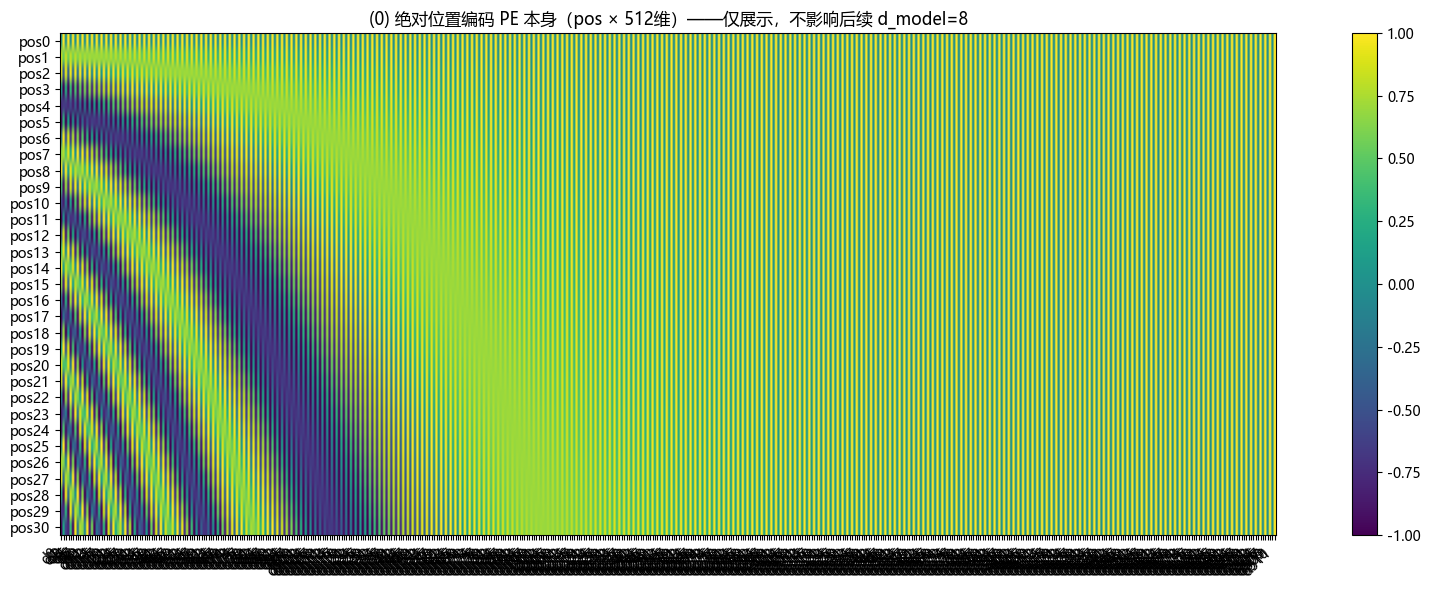

In [26]:
# ====== 只用于展示：512维绝对位置编码 PE 热力图 ======
d_pe_show = 512
max_pos_show = min(S_pad, 60)  # 512维会很宽，建议pos显示少一些，比如60

pe512 = sinusoidal_pe(max_len=max(S_pad, T_pad), d_model=d_pe_show, device=DEVICE)  # (max_len,512)
pe512_show = pe512[:max_pos_show].detach().cpu()  # (pos,512)

show_matrix(
    pe512_show,
    row_labels=[f"pos{i}" for i in range(max_pos_show)],
    col_labels=[f"d{j}" for j in range(d_pe_show)],
    title="(0) 绝对位置编码 PE 本身（pos × 512维）——仅展示，不影响后续 d_model=8",
    figsize=(16,6),   # 宽一点
    annotate=False
)


Cell 7：Q/K/V 线性层 + 热力图（单样本 & batch）

X_single: (20, 8) Q_single: (20, 8)
X_batch: (32, 31, 8) Q_batch: (32, 31, 8)


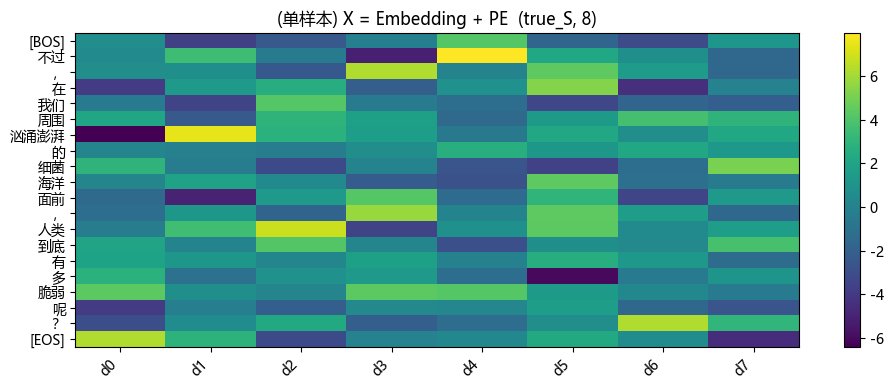

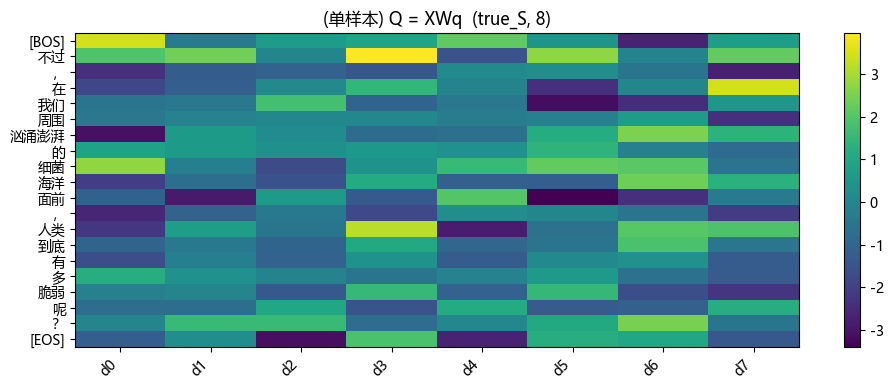

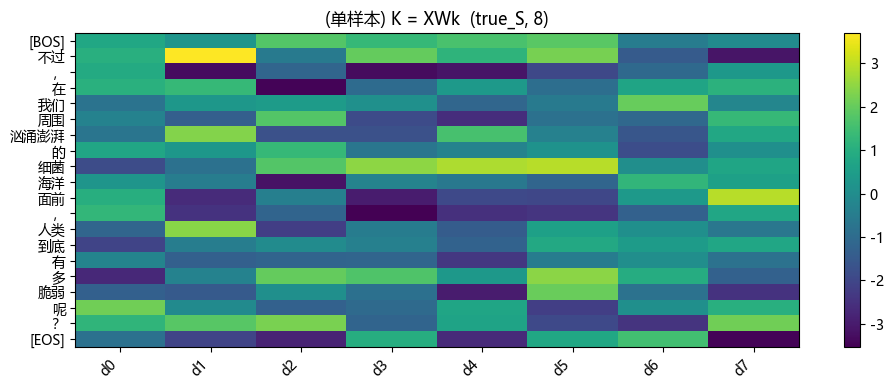

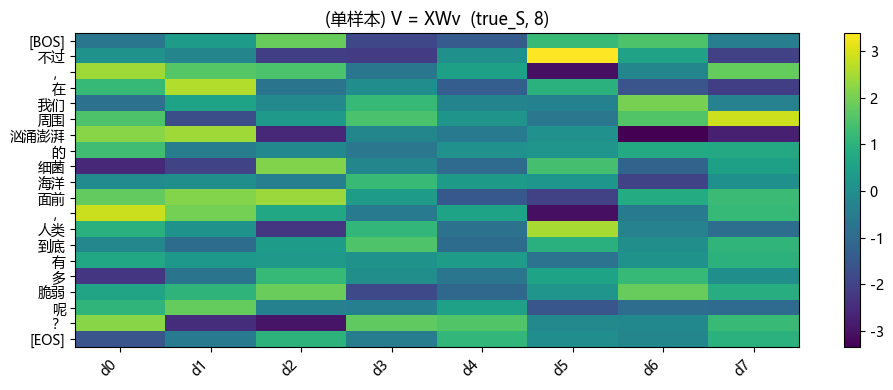

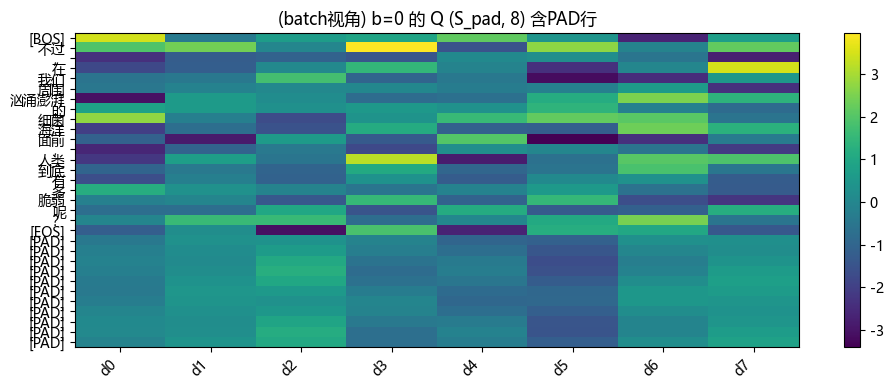

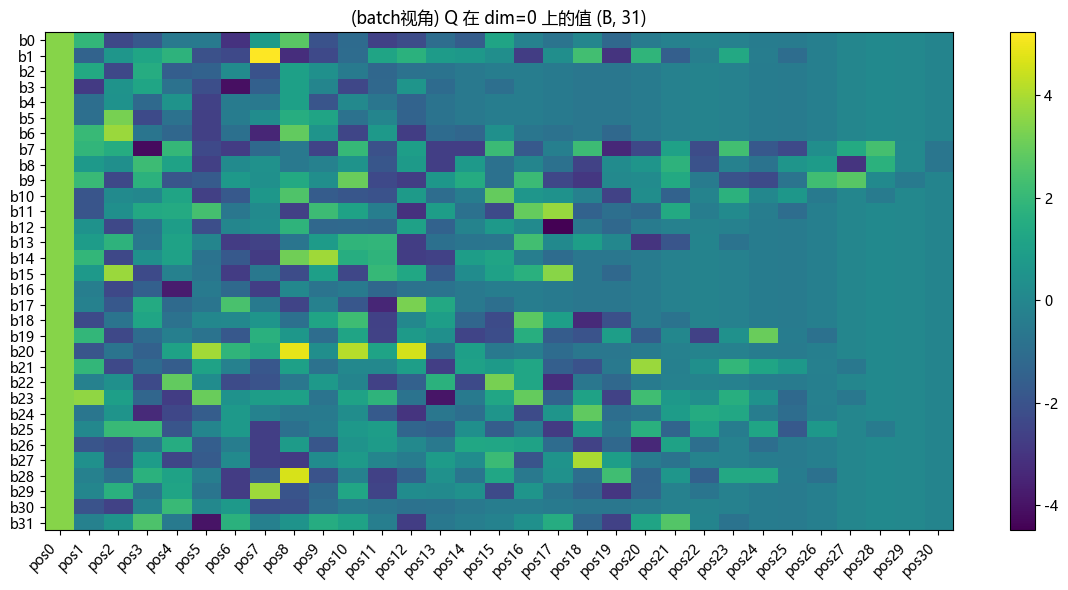

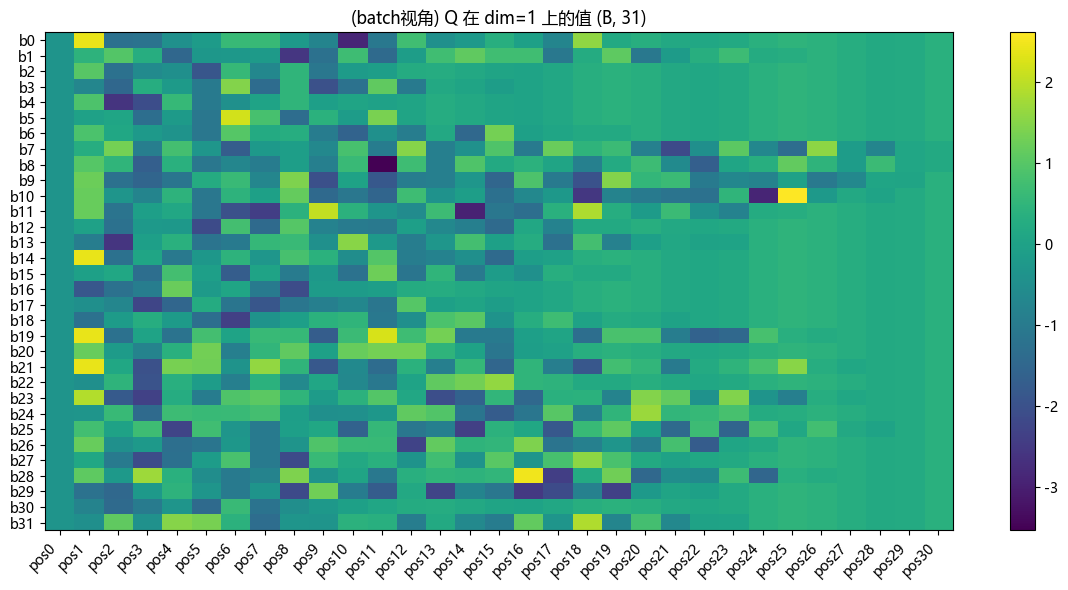

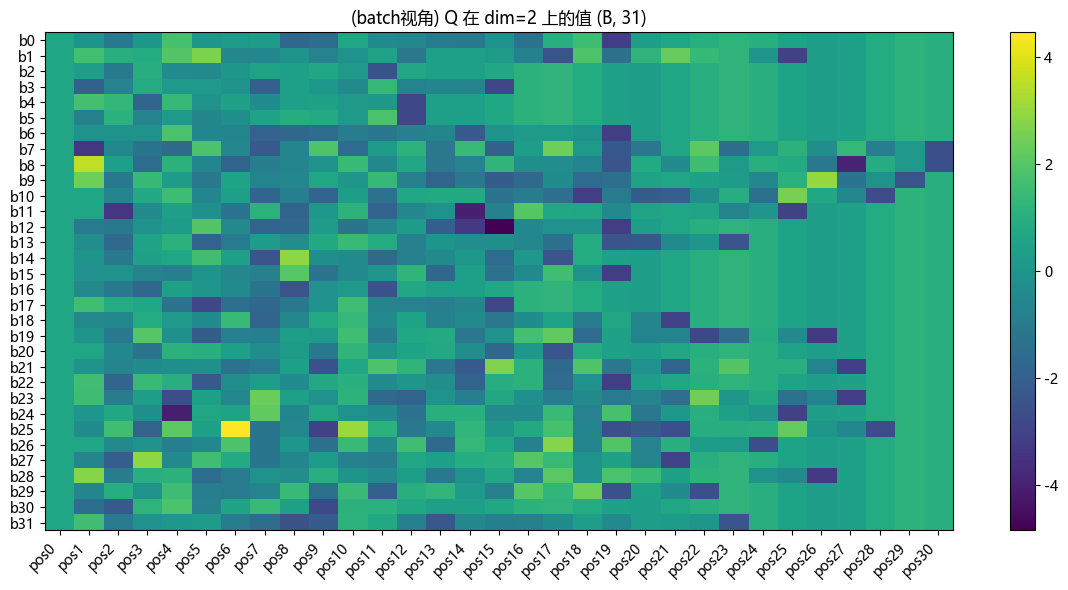

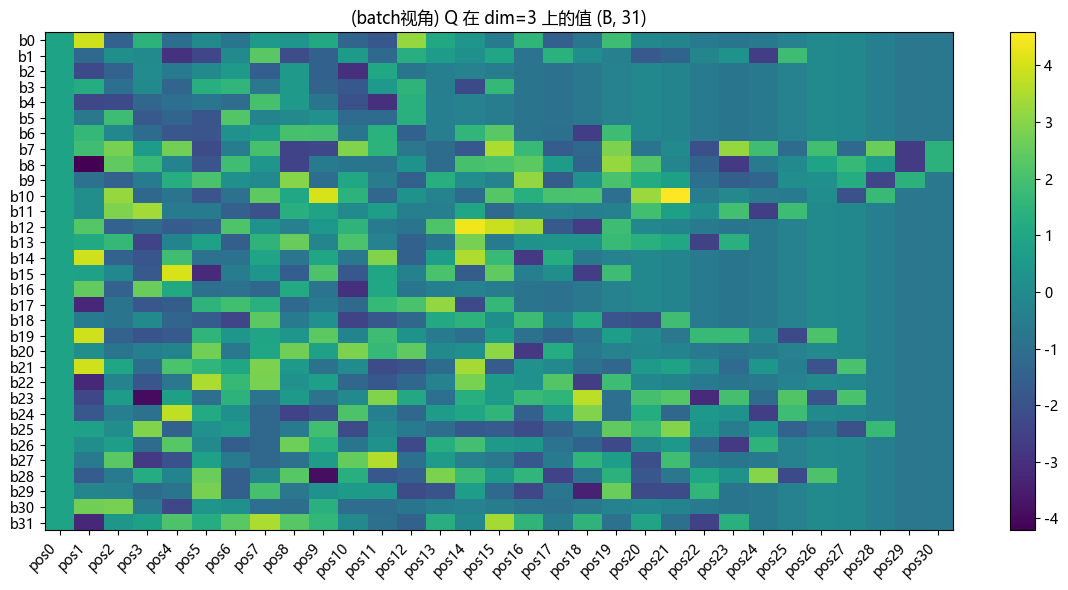

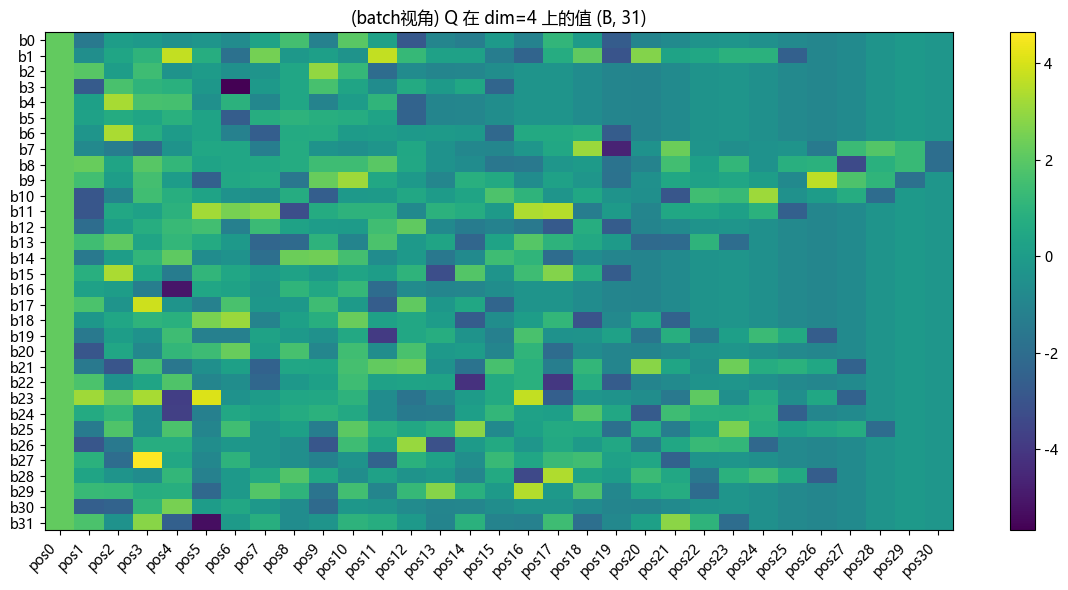

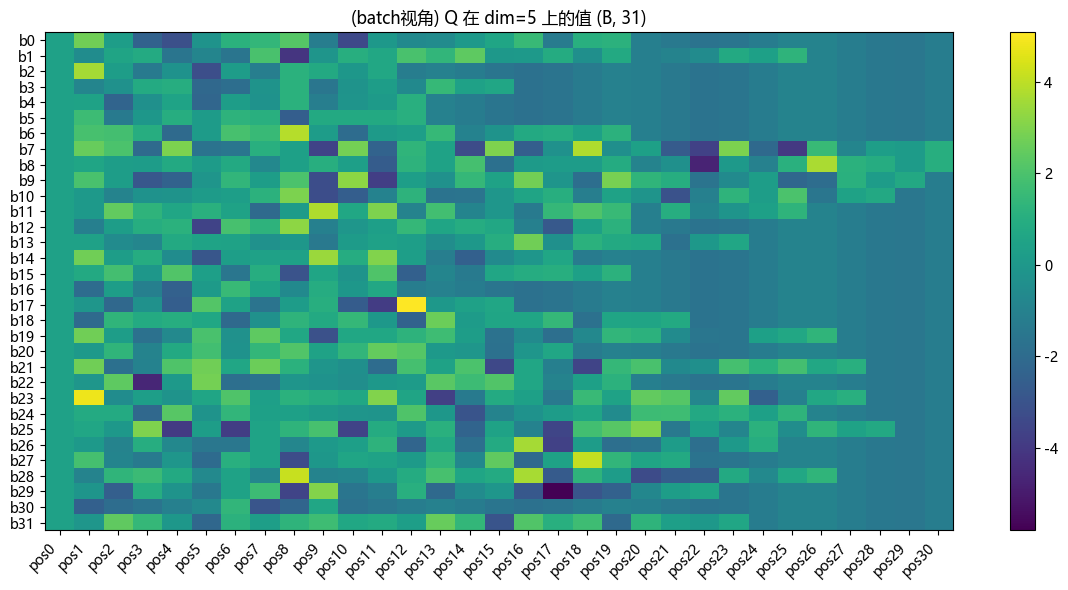

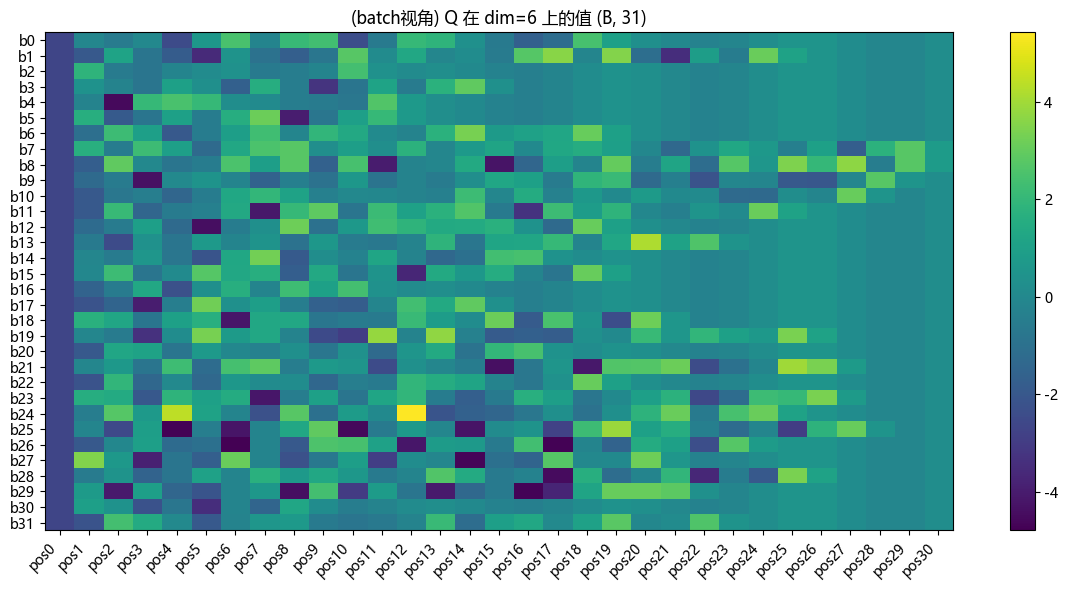

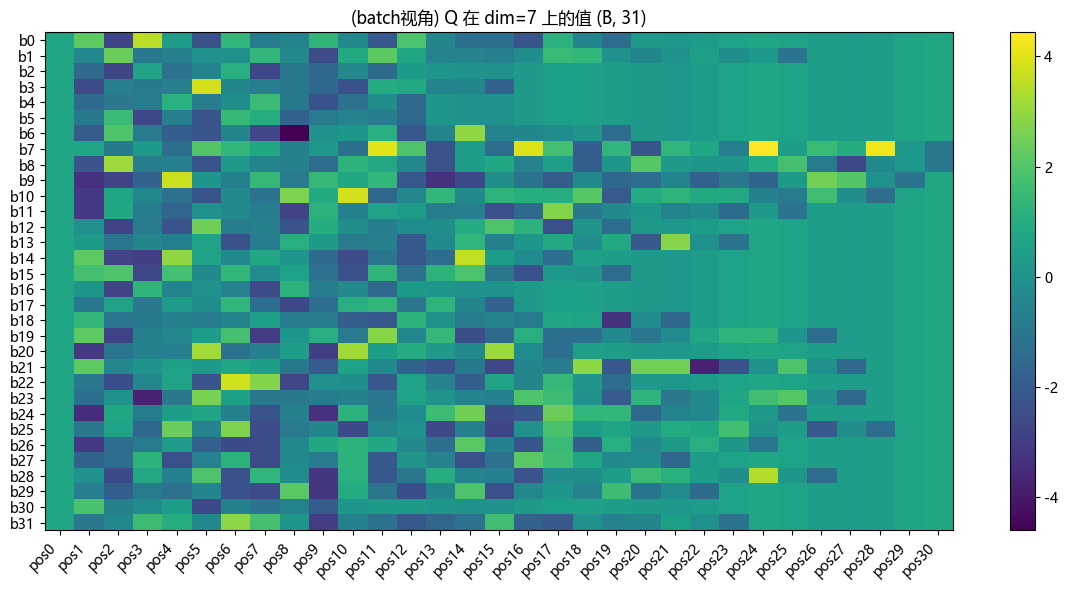

In [27]:
# ====== Cell 7: Q/K/V 线性变换（d_model=8），单样本 vs batch ======
import torch
import torch.nn as nn

# 1) 定义三组线性层（Wq, Wk, Wv）
# 输出维度仍然是 d_model=8，方便你继续看矩阵
Wq = nn.Linear(d_model, d_model, bias=False).to(DEVICE)
Wk = nn.Linear(d_model, d_model, bias=False).to(DEVICE)
Wv = nn.Linear(d_model, d_model, bias=False).to(DEVICE)

# 2) 单样本：X -> Q,K,V
X_single = src_after_single               # (true_S, 8)  在DEVICE上
Q_single = Wq(X_single)                   # (true_S, 8)
K_single = Wk(X_single)                   # (true_S, 8)
V_single = Wv(X_single)                   # (true_S, 8)

print("X_single:", tuple(X_single.shape), "Q_single:", tuple(Q_single.shape))

# 3) batch：X -> Q,K,V
X_batch = src_after_batch                 # (B, S_pad, 8) 在DEVICE上
Q_batch = Wq(X_batch)                     # (B, S_pad, 8)
K_batch = Wk(X_batch)                     # (B, S_pad, 8)
V_batch = Wv(X_batch)                     # (B, S_pad, 8)

print("X_batch:", tuple(X_batch.shape), "Q_batch:", tuple(Q_batch.shape))

# ====== 可视化（单样本）=====
# 行=token，列=8维
show_matrix(X_single.detach().cpu(), row_labels=src_tokens, col_labels=[f"d{j}" for j in range(d_model)],
            title="(单样本) X = Embedding + PE  (true_S, 8)", figsize=(10,4), annotate=False)

show_matrix(Q_single.detach().cpu(), row_labels=src_tokens, col_labels=[f"d{j}" for j in range(d_model)],
            title="(单样本) Q = XWq  (true_S, 8)", figsize=(10,4), annotate=False)

show_matrix(K_single.detach().cpu(), row_labels=src_tokens, col_labels=[f"d{j}" for j in range(d_model)],
            title="(单样本) K = XWk  (true_S, 8)", figsize=(10,4), annotate=False)

show_matrix(V_single.detach().cpu(), row_labels=src_tokens, col_labels=[f"d{j}" for j in range(d_model)],
            title="(单样本) V = XWv  (true_S, 8)", figsize=(10,4), annotate=False)

# ====== 可视化（batch）=====
# 方式A：只看 b=0 的 pad 后长度（含PAD），行标签用 src_tokens_full
b0 = 0
src_tokens_full = [zh_itos[int(i)] for i in src_ids[b0].tolist()]  # 含PAD
show_matrix(Q_batch[b0].detach().cpu(), row_labels=src_tokens_full, col_labels=[f"d{j}" for j in range(d_model)],
            title="(batch视角) b=0 的 Q (S_pad, 8) 含PAD行", figsize=(10,4), annotate=False)

# 方式B：看所有样本在某个维度上的值 (B, pos)
max_col = min(S_pad, 35)
for dim in range(d_model):
    mat_BS = Q_batch[:, :max_col, dim].detach().cpu()  # (B, max_col)
    show_matrix(
        mat_BS,
        row_labels=[f"b{i}" for i in range(B)],
        col_labels=[f"pos{j}" for j in range(max_col)],
        title=f"(batch视角) Q 在 dim={dim} 上的值 (B, {max_col})",
        figsize=(12,6),
        annotate=False
    )


Cell 8：Encoder Self-Attention（单头）scores / mask / softmax / context

scores0: (31, 31) attn0: (31, 31) ctx0: (31, 8)


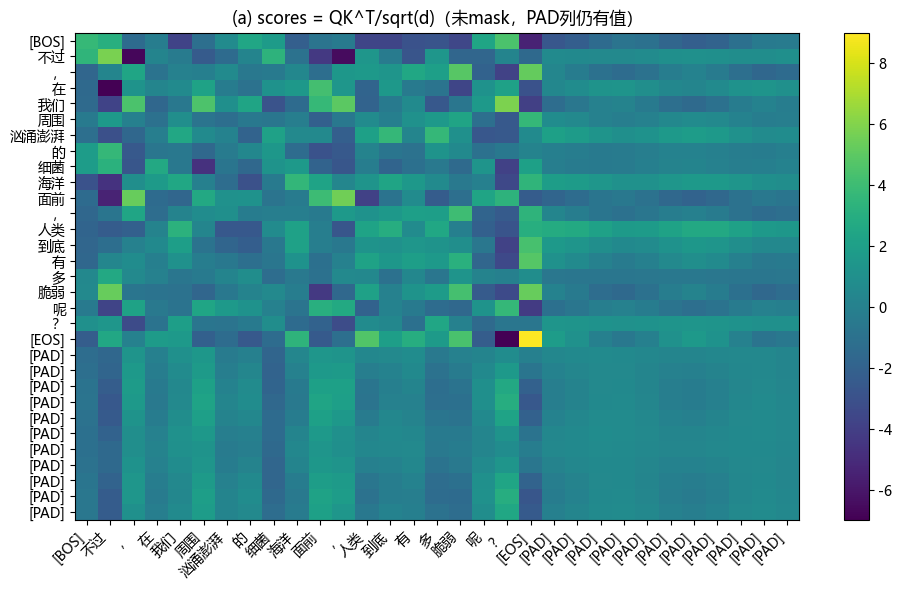

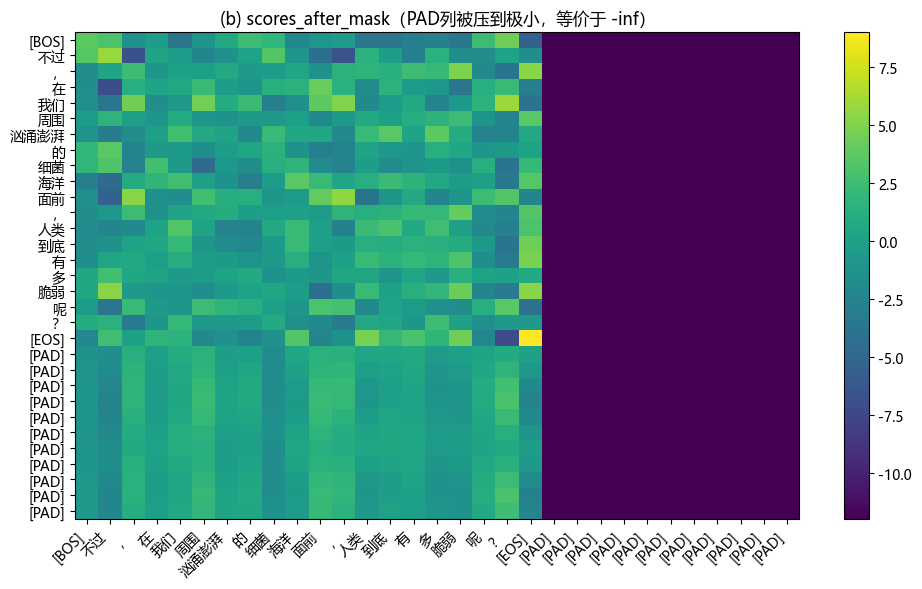

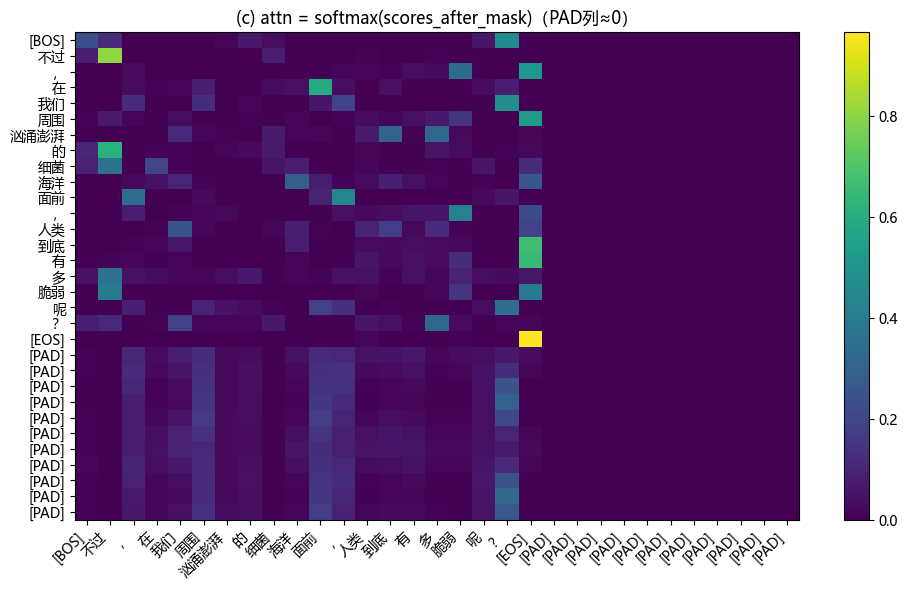

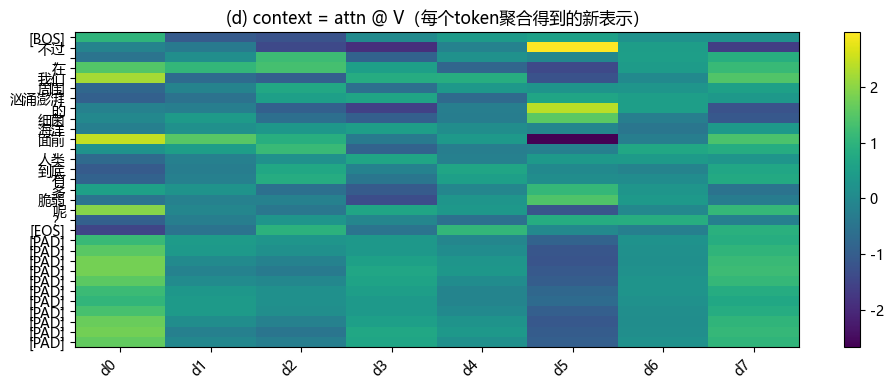


[检查] attn 每行加和（前10个）: [1.0000001  1.         1.         0.99999994 0.99999994 0.9999999
 1.         0.9999999  1.         1.0000001 ]
[检查] 分配到 PAD 列的总注意力（应≈0）: 0.0

[解释] Query位置 t=1 token='不过' 最关注的 8 个Key：
  -> key pos  1 token='不过'  attn=0.8104
  -> key pos  0 token='[BOS]'  attn=0.0804
  -> key pos  8 token='细菌'  attn=0.0724
  -> key pos 15 token='多'  attn=0.0102
  -> key pos 12 token='人类'  attn=0.0100
  -> key pos  3 token='在'  attn=0.0032
  -> key pos  7 token='的'  attn=0.0031
  -> key pos 18 token='？'  attn=0.0031


In [28]:
# ====== Cell 8: Attention scores -> mask -> softmax -> context（d_model=8）=====
import math
import torch

b = 0  # 看 batch 中第0条
S_pad = src_ids.size(1)
D = d_model

# 取 b=0 的 Q,K,V（含PAD行）
Q0 = Q_batch[b]  # (S_pad, D)
K0 = K_batch[b]  # (S_pad, D)
V0 = V_batch[b]  # (S_pad, D)

# token 标签（含PAD）
src_tokens_full = [zh_itos[int(i)] for i in src_ids[b].tolist()]

# 1) scores = QK^T / sqrt(D)   -> (S_pad, S_pad)
scores0 = (Q0 @ K0.T) / math.sqrt(D)

# 2) padding mask：遮住“Key端”的PAD列（让任何 Query 都不能去看 PAD token）
# src_kpm[b] 是 (S_pad,) True=PAD
kpm0 = src_kpm[b].to(scores0.device)             # (S_pad,)
scores0_masked = scores0.masked_fill(kpm0.unsqueeze(0), float("-inf"))  # (S_pad, S_pad)

# 3) softmax 得到注意力权重
attn0 = torch.softmax(scores0_masked, dim=-1)    # (S_pad, S_pad)

# 4) context = attn @ V
ctx0 = attn0 @ V0                                # (S_pad, D)

print("scores0:", tuple(scores0.shape), "attn0:", tuple(attn0.shape), "ctx0:", tuple(ctx0.shape))

# ====== 可视化（强烈建议按这个顺序看）=====
max_show = min(S_pad, 35)

# (a) scores（未mask）
show_attention(scores0[:max_show, :max_show].detach().cpu(),
               src_tokens_full[:max_show], src_tokens_full[:max_show],
               title="(a) scores = QK^T/sqrt(d)（未mask，PAD列仍有值）", figsize=(10,6), annotate=False)

# (b) scores（mask后）：PAD 列会变成 -inf（显示上会很极端）
# 为了更直观，给一个“可视化版本”：把 -inf 替换成一个很小的数
scores_vis = scores0_masked[:max_show, :max_show].detach().cpu().clone()
scores_vis[torch.isinf(scores_vis)] = scores_vis[~torch.isinf(scores_vis)].min() - 5.0

show_attention(scores_vis,
               src_tokens_full[:max_show], src_tokens_full[:max_show],
               title="(b) scores_after_mask（PAD列被压到极小，等价于 -inf）", figsize=(10,6), annotate=False)

# (c) attn（softmax后）：PAD列应该接近 0
show_attention(attn0[:max_show, :max_show].detach().cpu(),
               src_tokens_full[:max_show], src_tokens_full[:max_show],
               title="(c) attn = softmax(scores_after_mask)（PAD列≈0）", figsize=(10,6), annotate=False)

# (d) context（输出）：每个位置得到一个 8维向量
show_matrix(ctx0[:max_show].detach().cpu(),
            row_labels=src_tokens_full[:max_show],
            col_labels=[f"d{j}" for j in range(D)],
            title="(d) context = attn @ V（每个token聚合得到的新表示）",
            figsize=(10,4), annotate=False)

# ====== 数值检查：注意力每一行加和≈1，且 PAD 列权重≈0 ======
row_sum = attn0.sum(dim=-1)  # (S_pad,)
pad_cols_sum = attn0[:, kpm0].sum().item() if kpm0.any() else 0.0

print("\n[检查] attn 每行加和（前10个）:", row_sum[:10].detach().cpu().numpy())
print("[检查] 分配到 PAD 列的总注意力（应≈0）:", pad_cols_sum)

# ====== 再来一个“单行解释”：某个 token 最关注谁 ======
t = 1  # 看第 t 个位置（你可以改）
weights = attn0[t].detach().cpu()
topk = 8
vals, idx = torch.topk(weights, k=topk)
print(f"\n[解释] Query位置 t={t} token='{src_tokens_full[t]}' 最关注的 {topk} 个Key：")
for v, j in zip(vals.tolist(), idx.tolist()):
    print(f"  -> key pos {j:>2} token='{src_tokens_full[j]}'  attn={v:.4f}")


In [30]:
# ====== Cell: 保存完整矩阵到 txt（不会被 Jupyter 截断）=====
import numpy as np
import torch
import math
from pathlib import Path

def _to_numpy(x):
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().float().numpy()
    return x

def format_matrix_with_tokens(mat, row_tokens, col_tokens, title="", fmt="{:7.3f}", inf_str="  -inf "):
    A = _to_numpy(mat)
    R, C = A.shape

    lines = []
    lines.append("=" * 120)
    lines.append(title)
    lines.append("=" * 120)

    # 列头
    header = [" " * 12] + [f"{tok:>10}"[:10] for tok in col_tokens]
    lines.append("".join(header))

    for i in range(R):
        row_name = f"{row_tokens[i]:>10}"[:10]
        line = [f"{row_name:>12}"]
        for j in range(C):
            v = A[i, j]
            if np.isinf(v):
                s = inf_str
            else:
                s = fmt.format(v)
            line.append(f"{s:>10}")
        lines.append("".join(line))
    return "\n".join(lines)

def format_vector_matrix(mat, row_tokens, title="", fmt="{:7.3f}"):
    A = _to_numpy(mat)
    R, D = A.shape
    lines = []
    lines.append("=" * 120)
    lines.append(title)
    lines.append("=" * 120)
    header = [" " * 12] + [f"d{j:02d}".rjust(10) for j in range(D)]
    lines.append("".join(header))
    for i in range(R):
        row_name = f"{row_tokens[i]:>10}"[:10]
        vals = "".join([f"{fmt.format(A[i,j]):>10}" for j in range(D)])
        lines.append(f"{row_name:>12}" + vals)
    return "\n".join(lines)

# ====== 取你当前 b=0 的矩阵（含PAD版本 + 有效版本都存）=====
b = 0
D = d_model
S_pad = src_ids.size(1)

src_tokens_full = [zh_itos[int(i)] for i in src_ids[b].tolist()]
true_S = int((~src_kpm[b]).sum().item())
src_tokens = src_tokens_full[:true_S]

# 有效区域（true_S）
Q0 = Q_batch[b, :true_S]
K0 = K_batch[b, :true_S]
V0 = V_batch[b, :true_S]
scores = (Q0 @ K0.T) / math.sqrt(D)
attn   = torch.softmax(scores, dim=-1)
ctx    = attn @ V0

# 含PAD（S_pad）
Qp = Q_batch[b]
Kp = K_batch[b]
Vp = V_batch[b]
scores_p = (Qp @ Kp.T) / math.sqrt(D)
kpm0 = src_kpm[b].to(scores_p.device)
scores_p_masked = scores_p.masked_fill(kpm0.unsqueeze(0), float("-inf"))
attn_p = torch.softmax(scores_p_masked, dim=-1)
ctx_p  = attn_p @ Vp

out_path = Path("attention_matrices_full.txt")

content = []
content.append(f"b={b}, true_S={true_S}, S_pad={S_pad}, D={D}\n")
content.append(format_matrix_with_tokens(scores, src_tokens, src_tokens,
    title="(a) true_S版 scores = QK^T/sqrt(d)"))
content.append("\n")
content.append(format_matrix_with_tokens(attn, src_tokens, src_tokens,
    title="(b) true_S版 attn = softmax(scores)"))
content.append("\n")
content.append(format_vector_matrix(ctx, src_tokens,
    title="(c) true_S版 ctx = attn @ V (每行8维)"))
content.append("\n\n")

content.append(format_matrix_with_tokens(scores_p, src_tokens_full, src_tokens_full,
    title="(d1) S_pad版 scores（未mask，包含PAD）"))
content.append("\n")
content.append(format_matrix_with_tokens(scores_p_masked, src_tokens_full, src_tokens_full,
    title="(d2) S_pad版 scores_after_mask（PAD列=-inf）"))
content.append("\n")
content.append(format_matrix_with_tokens(attn_p, src_tokens_full, src_tokens_full,
    title="(d3) S_pad版 attn（softmax后 PAD列≈0）"))
content.append("\n")
content.append(format_vector_matrix(ctx_p, src_tokens_full,
    title="(d4) S_pad版 ctx = attn @ V（包含PAD行）"))

out_path.write_text("\n".join(content), encoding="utf-8")
print("✅ 已写入文件：", out_path.resolve())
print("打开这个 txt 就能看到完整矩阵（不会被截断）。")


✅ 已写入文件： C:\Users\31392\Desktop\writebyhand\attention_matrices_full.txt
打开这个 txt 就能看到完整矩阵（不会被截断）。


Cell 9：对比 Key-only vs Query+Key mask（含解释与检查）

In [32]:
import numpy as np
import torch
import math
from pathlib import Path

def _to_numpy(x):
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().float().numpy()
    return x

def format_matrix_with_tokens(mat, row_tokens, col_tokens, title="", fmt="{:7.3f}", inf_str="  -inf "):
    A = _to_numpy(mat)
    R, C = A.shape
    lines = []
    lines.append("=" * 140)
    lines.append(title)
    lines.append("=" * 140)

    # 列头
    header = [" " * 12] + [f"{tok:>10}"[:10] for tok in col_tokens]
    lines.append("".join(header))

    for i in range(R):
        row_name = f"{row_tokens[i]:>10}"[:10]
        line = [f"{row_name:>12}"]
        for j in range(C):
            v = A[i, j]
            if np.isinf(v):
                s = inf_str
            else:
                s = fmt.format(v)
            line.append(f"{s:>10}")
        lines.append("".join(line))
    return "\n".join(lines)

def format_vector_matrix(mat, row_tokens, title="", fmt="{:7.3f}"):
    A = _to_numpy(mat)
    R, D = A.shape
    lines = []
    lines.append("=" * 140)
    lines.append(title)
    lines.append("=" * 140)
    header = [" " * 12] + [f"d{j:02d}".rjust(10) for j in range(D)]
    lines.append("".join(header))
    for i in range(R):
        row_name = f"{row_tokens[i]:>10}"[:10]
        vals = "".join([f"{fmt.format(A[i,j]):>10}" for j in range(D)])
        lines.append(f"{row_name:>12}" + vals)
    return "\n".join(lines)

# ====== 重新计算一遍（确保变量齐全、可直接运行）=====
b = 0
D = d_model
S_pad = src_ids.size(1)

src_tokens_full = [zh_itos[int(i)] for i in src_ids[b].tolist()]
kpm0 = src_kpm[b].to(DEVICE)  # (S_pad,) True=PAD

Qp = Q_batch[b]        # (S_pad,D)
Kp = K_batch[b]
Vp = V_batch[b]
scores_p = (Qp @ Kp.T) / math.sqrt(D)  # (S_pad,S_pad)

# 方案A：只mask Key列（PAD列=-inf）
scores_A = scores_p.masked_fill(kpm0.unsqueeze(0), float("-inf"))
attn_A = torch.softmax(scores_A, dim=-1)
ctx_A = attn_A @ Vp

# 方案B：mask Key列 + Query行（PAD行&PAD列=-inf），softmax后nan->0
scores_B = scores_p.clone()
scores_B = scores_B.masked_fill(kpm0.unsqueeze(0), float("-inf"))  # Key列
scores_B = scores_B.masked_fill(kpm0.unsqueeze(1), float("-inf"))  # Query行
attn_B = torch.softmax(scores_B, dim=-1)
attn_B = torch.nan_to_num(attn_B, nan=0.0)
ctx_B = attn_B @ Vp

# ====== 统计检查 ======
pad_idx = torch.where(kpm0)[0]
real_idx = torch.where(~kpm0)[0]

pad_col_sum_A = attn_A[:, pad_idx].sum().item() if len(pad_idx)>0 else 0.0
pad_col_sum_B = attn_B[:, pad_idx].sum().item() if len(pad_idx)>0 else 0.0
pad_row_sum_A = attn_A[pad_idx, :].sum().item() if len(pad_idx)>0 else 0.0
pad_row_sum_B = attn_B[pad_idx, :].sum().item() if len(pad_idx)>0 else 0.0

row_sum_A = attn_A[real_idx].sum(dim=-1).detach().cpu().numpy()
row_sum_B = attn_B[real_idx].sum(dim=-1).detach().cpu().numpy()

# ====== 写入文件 ======
out_path = Path("attention_mask_compare_full.txt")

content = []
content.append(f"b={b}, S_pad={S_pad}, D={D}, PAD_count={int(kpm0.sum().item())}, real_count={int((~kpm0).sum().item())}\n")
content.append("解释：\n"
              "scores[i,j] = <Q_i,K_j>/sqrt(d)：第i个位置(Query)对第j个位置(Key)的匹配分数\n"
              "attn[i,j] = softmax(scores[i,:])[j]：第i个位置对第j个位置分配的注意力概率（每行≈1；PAD列应≈0）\n"
              "ctx[i,:] = Σ_j attn[i,j]*V[j,:]：输出向量（这里d_model=8）\n"
              "方案A：只mask Key端PAD列（常用、不会NaN）\n"
              "方案B：mask Key列 + Query行（PAD行整行=-inf，softmax会NaN，所以用 nan->0 处理PAD行）\n")

content.append("\n[检查指标]\n")
content.append(f"方案A：PAD列注意力总和（应≈0） = {pad_col_sum_A}\n")
content.append(f"方案B：PAD列注意力总和（应≈0） = {pad_col_sum_B}\n")
content.append(f"方案A：PAD行注意力总和（不要求为0） = {pad_row_sum_A}\n")
content.append(f"方案B：PAD行注意力总和（应=0） = {pad_row_sum_B}\n")
content.append(f"方案A：真实行行和（前10） = {row_sum_A[:10].tolist()}\n")
content.append(f"方案B：真实行行和（前10） = {row_sum_B[:10].tolist()}\n")

content.append("\n")
content.append(format_matrix_with_tokens(scores_p, src_tokens_full, src_tokens_full,
    title="(0) scores_p（未mask，包含PAD）", fmt="{:7.3f}", inf_str="  -inf "))
content.append("\n\n")
content.append(format_matrix_with_tokens(scores_A, src_tokens_full, src_tokens_full,
    title="(A1) 方案A：scores_A（只mask PAD列=-inf）", fmt="{:7.3f}", inf_str="  -inf "))
content.append("\n\n")
content.append(format_matrix_with_tokens(attn_A, src_tokens_full, src_tokens_full,
    title="(A2) 方案A：attn_A = softmax(scores_A)（PAD列≈0；PAD行仍是分布）", fmt="{:7.3f}"))
content.append("\n\n")
content.append(format_vector_matrix(ctx_A, src_tokens_full,
    title="(A3) 方案A：ctx_A = attn_A @ V（每行8维，包含PAD行）", fmt="{:7.3f}"))
content.append("\n\n")
content.append(format_matrix_with_tokens(scores_B, src_tokens_full, src_tokens_full,
    title="(B1) 方案B：scores_B（mask PAD列 + PAD行，全=-inf 的PAD行会导致softmax NaN）", fmt="{:7.3f}", inf_str="  -inf "))
content.append("\n\n")
content.append(format_matrix_with_tokens(attn_B, src_tokens_full, src_tokens_full,
    title="(B2) 方案B：attn_B（softmax后 nan->0，所以PAD行全0，PAD列全0）", fmt="{:7.3f}"))
content.append("\n\n")
content.append(format_vector_matrix(ctx_B, src_tokens_full,
    title="(B3) 方案B：ctx_B = attn_B @ V（PAD行输出会变成全0向量）", fmt="{:7.3f}"))

out_path.write_text("\n".join(content), encoding="utf-8")
print("✅ 已写入：", out_path.resolve())
print("打开 attention_mask_compare_full.txt 可查看完整矩阵（不会被Jupyter截断）。")


✅ 已写入： C:\Users\31392\Desktop\writebyhand\attention_mask_compare_full.txt
打开 attention_mask_compare_full.txt 可查看完整矩阵（不会被Jupyter截断）。


Cell 10：Multi-Head Attention（H=2）reshape→每头算→concat 回来

D = 8 H = 2 d_head = 4
Qh: (32, 2, 31, 4) Kh: (32, 2, 31, 4) Vh: (32, 2, 31, 4)
scores_h: (32, 2, 31, 31)
ctx_h: (32, 2, 31, 4) ctx_mh: (32, 31, 8)

[单样本] true_S = 20 显示前 20 个 token
tokens: [BOS] 不过 ， 在 我们 周围 汹涌澎湃 的 细菌 海洋 面前 ， 人类 到底 有 多 脆弱 呢 ？ [EOS]

head=0 | Query pos t=4 token='我们' top-attend:
  -> key pos  5 token='周围' attn=0.3176
  -> key pos 18 token='？' attn=0.1123
  -> key pos 15 token='多' attn=0.0967
  -> key pos 10 token='面前' attn=0.0750
  -> key pos  7 token='的' attn=0.0592
  -> key pos 16 token='脆弱' attn=0.0580
  -> key pos  2 token='，' attn=0.0542
  -> key pos  8 token='细菌' attn=0.0471

head=1 | Query pos t=4 token='我们' top-attend:
  -> key pos 18 token='？' attn=0.4519
  -> key pos 11 token='，' attn=0.3248
  -> key pos  2 token='，' attn=0.1237
  -> key pos 10 token='面前' attn=0.0331
  -> key pos  5 token='周围' attn=0.0247
  -> key pos 17 token='呢' attn=0.0226
  -> key pos  6 token='汹涌澎湃' attn=0.0075
  -> key pos  7 token='的' attn=0.0058


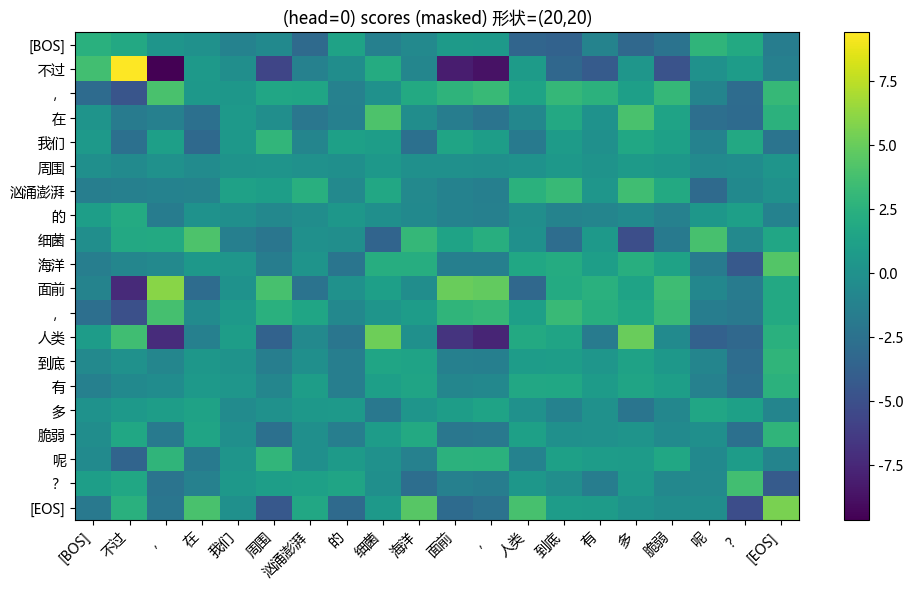

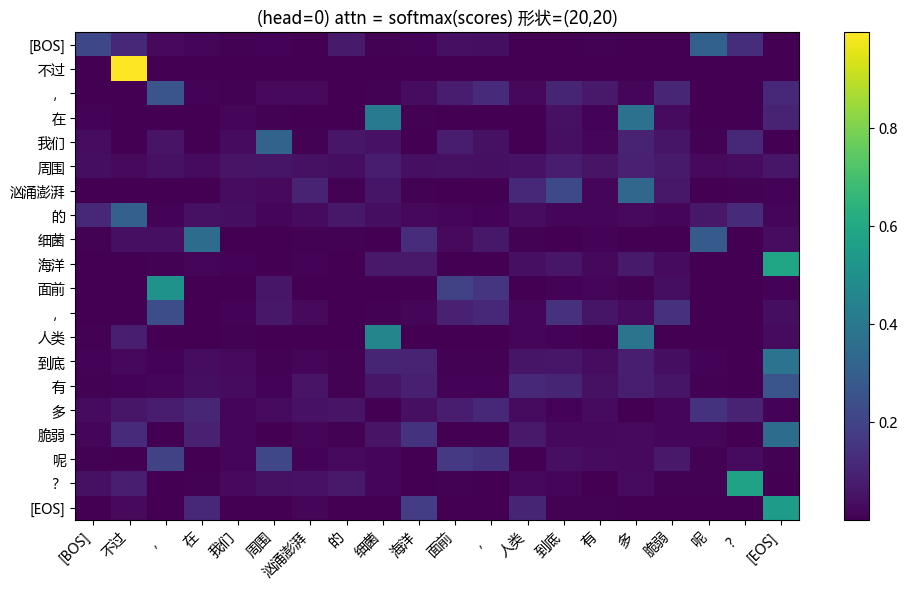

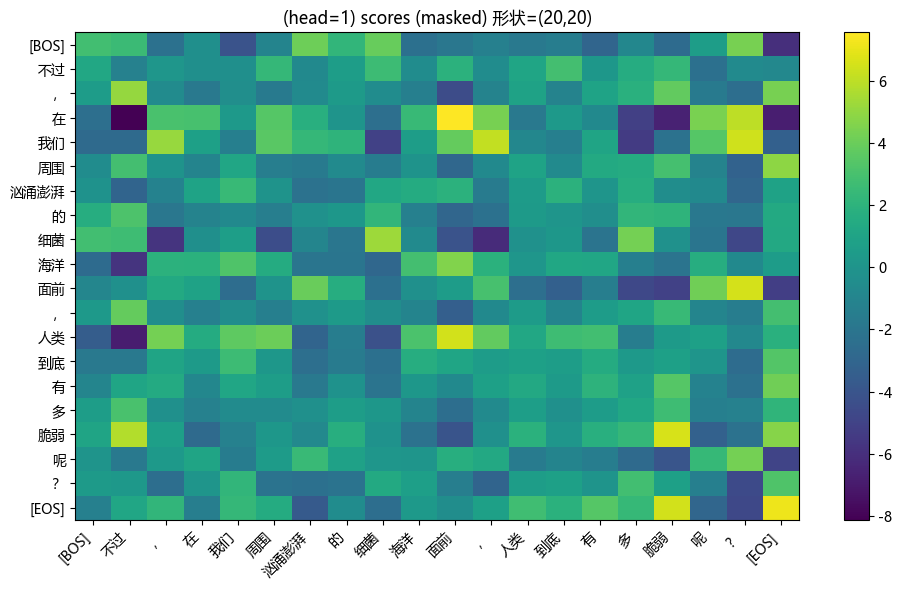

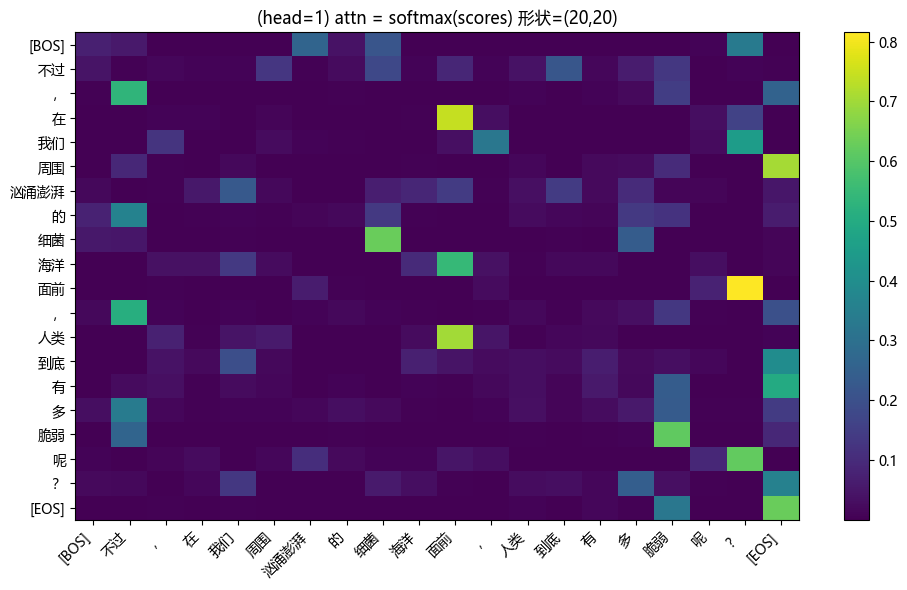

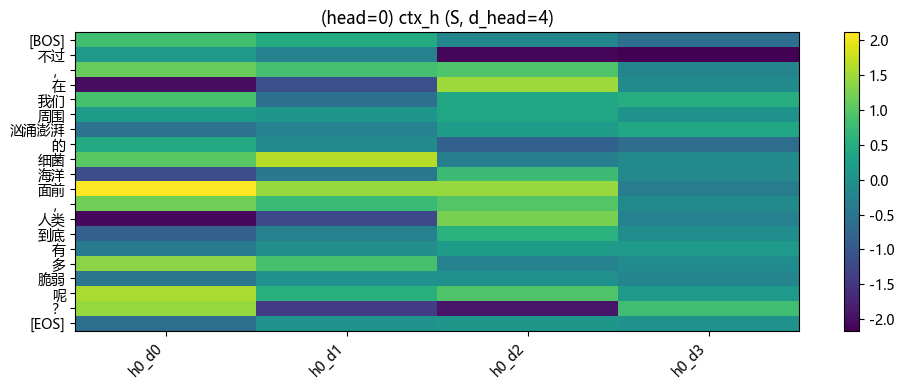

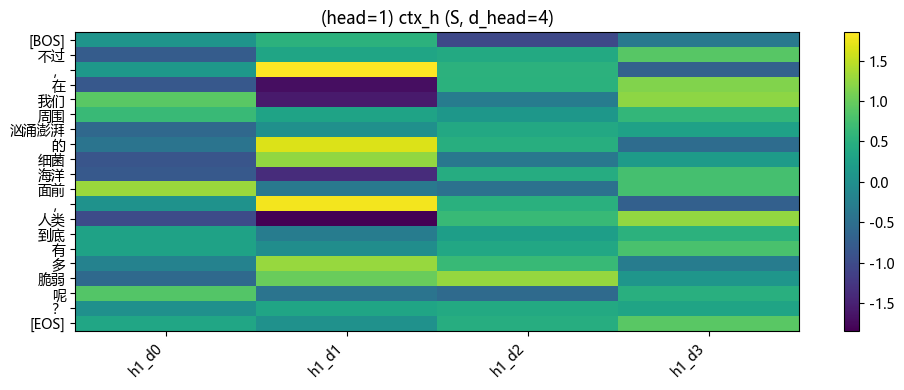

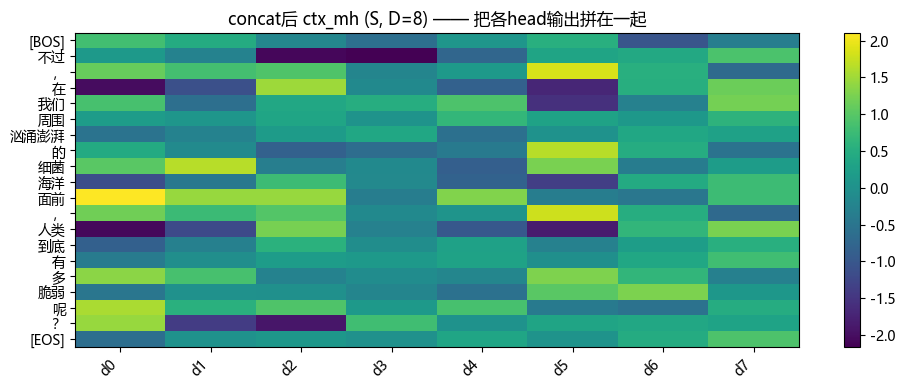

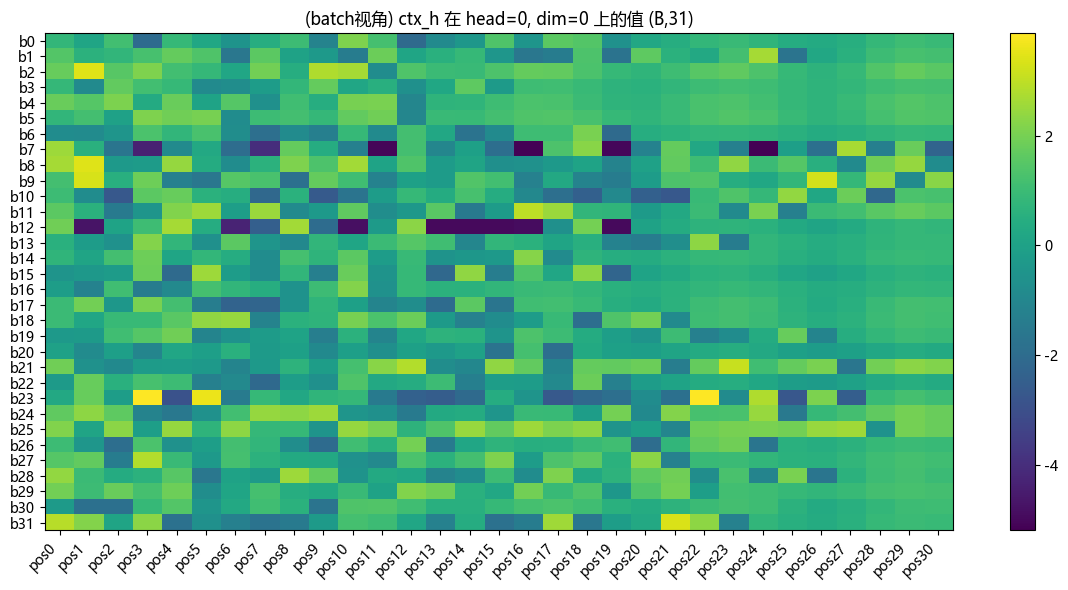


[检查] 全batch所有head分配到PAD列的注意力总和（应≈0）: 0.0


In [34]:
# ====== Cell 10: Multi-Head Attention (H=2) reshape -> per-head -> concat ======
import torch
import math

# ---------- 超参数 ----------
H = 2
D = d_model
assert D % H == 0
d_head = D // H
print("D =", D, "H =", H, "d_head =", d_head)

B, S_pad, _ = Q_batch.shape

# ---------- 工具：把 (B,S,D) -> (B,H,S,d_head) ----------
def split_heads(x, H):
    B, S, D = x.shape
    d_head = D // H
    # (B,S,D) -> (B,S,H,d_head) -> (B,H,S,d_head)
    return x.view(B, S, H, d_head).permute(0, 2, 1, 3).contiguous()

# ---------- 工具：把 (B,H,S,d_head) -> (B,S,D) ----------
def combine_heads(x):
    # x: (B,H,S,d_head)
    B, H, S, dh = x.shape
    # (B,H,S,dh) -> (B,S,H,dh) -> (B,S,H*dh)
    return x.permute(0, 2, 1, 3).contiguous().view(B, S, H * dh)

# 1) 拆分 head
Qh = split_heads(Q_batch, H)  # (B,H,S,d_head)
Kh = split_heads(K_batch, H)
Vh = split_heads(V_batch, H)
print("Qh:", tuple(Qh.shape), "Kh:", tuple(Kh.shape), "Vh:", tuple(Vh.shape))

# 2) 每个 head 单独算 scores: (B,H,S,S)
scores_h = torch.matmul(Qh, Kh.transpose(-2, -1)) / math.sqrt(d_head)  # (B,H,S,S)
print("scores_h:", tuple(scores_h.shape))

# 3) mask：仍然 mask Key 的 PAD 列（对每个 head 一样）
# src_kpm: (B,S) True=PAD
kpm = src_kpm.to(scores_h.device)  # (B,S)
# 扩展到 (B,1,1,S) 以便广播到 (B,H,S,S) 的最后一维（列）
scores_h_masked = scores_h.masked_fill(kpm[:, None, None, :], float("-inf"))

# 4) softmax 得到 attn: (B,H,S,S)
attn_h = torch.softmax(scores_h_masked, dim=-1)

# 5) context per head: (B,H,S,d_head)
ctx_h = torch.matmul(attn_h, Vh)

# 6) concat 回来: (B,S,D)
ctx_mh = combine_heads(ctx_h)
print("ctx_h:", tuple(ctx_h.shape), "ctx_mh:", tuple(ctx_mh.shape))

# ========== 单样本可视化（b=0）==========
b = 0
src_tokens_full = [zh_itos[int(i)] for i in src_ids[b].tolist()]
true_S = int((~src_kpm[b]).sum().item())
max_show = min(true_S, 20)   # 打印/画前20个 token，避免太大

print("\n[单样本] true_S =", true_S, "显示前", max_show, "个 token")
print("tokens:", " ".join(src_tokens_full[:max_show]))

# 选一个位置 t 看它“在每个 head 上关注谁”
t = 4  # 你可以改
for h in range(H):
    w = attn_h[b, h, t, :true_S].detach().cpu()  # 只看真实 token 范围
    vals, idx = torch.topk(w, k=min(8, true_S))
    print(f"\nhead={h} | Query pos t={t} token='{src_tokens_full[t]}' top-attend:")
    for v, j in zip(vals.tolist(), idx.tolist()):
        print(f"  -> key pos {j:>2} token='{src_tokens_full[j]}' attn={v:.4f}")

# ========== 可视化：每个 head 的 scores/attn（取 b=0，截到 true_S）==========
# 提示：scores 数值范围大，attn 更直观
for h in range(H):
    # scores/attn 都截断到真实 token 的前 max_show
    scores_vis = scores_h_masked[b, h, :max_show, :max_show].detach().cpu().clone()
    # 把 -inf 替换成极小值，便于显示
    if torch.isinf(scores_vis).any():
        finite_min = scores_vis[~torch.isinf(scores_vis)].min()
        scores_vis[torch.isinf(scores_vis)] = finite_min - 5.0

    show_attention(scores_vis,
                   src_tokens_full[:max_show], src_tokens_full[:max_show],
                   title=f"(head={h}) scores (masked) 形状=({max_show},{max_show})",
                   figsize=(10,6), annotate=False)

    show_attention(attn_h[b, h, :max_show, :max_show].detach().cpu(),
                   src_tokens_full[:max_show], src_tokens_full[:max_show],
                   title=f"(head={h}) attn = softmax(scores) 形状=({max_show},{max_show})",
                   figsize=(10,6), annotate=False)

# ========== 可视化：context 拼接前后 ==========
# ctx_h: (B,H,S,dh) 取 b=0, 前 max_show
for h in range(H):
    show_matrix(ctx_h[b, h, :max_show].detach().cpu(),
                row_labels=src_tokens_full[:max_show],
                col_labels=[f"h{h}_d{j}" for j in range(d_head)],
                title=f"(head={h}) ctx_h (S, d_head={d_head})",
                figsize=(10,4), annotate=False)

# concat 后 ctx_mh: (B,S,D)
show_matrix(ctx_mh[b, :max_show].detach().cpu(),
            row_labels=src_tokens_full[:max_show],
            col_labels=[f"d{j}" for j in range(D)],
            title="concat后 ctx_mh (S, D=8) —— 把各head输出拼在一起",
            figsize=(10,4), annotate=False)

# ========== batch 视角：看某个 head、某个 dim 的 (B,pos) ==========
max_col = min(S_pad, 35)
h_show = 0
dim_in_head = 0  # head内部的第0维
mat_BS = ctx_h[:, h_show, :max_col, dim_in_head].detach().cpu()  # (B, max_col)
show_matrix(mat_BS,
            row_labels=[f"b{i}" for i in range(B)],
            col_labels=[f"pos{j}" for j in range(max_col)],
            title=f"(batch视角) ctx_h 在 head={h_show}, dim={dim_in_head} 上的值 (B,{max_col})",
            figsize=(12,6), annotate=False)

# ========== 核心检查：PAD列注意力是否≈0（所有head一起） ==========
# kpm: (B,S) True=PAD
if kpm.any():
    # 扩展到 (B,1,1,S) 与 attn_h (B,H,S,S) 广播相乘
    pad_mask_cols = kpm[:, None, None, :].float()          # (B,1,1,S)
    pad_col_sum = (attn_h * pad_mask_cols).sum().item()
else:
    pad_col_sum = 0.0

print("\n[检查] 全batch所有head分配到PAD列的注意力总和（应≈0）:", pad_col_sum)



Cell 11：Wo + Residual + LayerNorm（含可视化）

ctx_mh: (32, 31, 8) attn_out=Wo(ctx_mh): (32, 31, 8)
res=X+attn_out: (32, 31, 8)
ln_out=LN(res): (32, 31, 8)


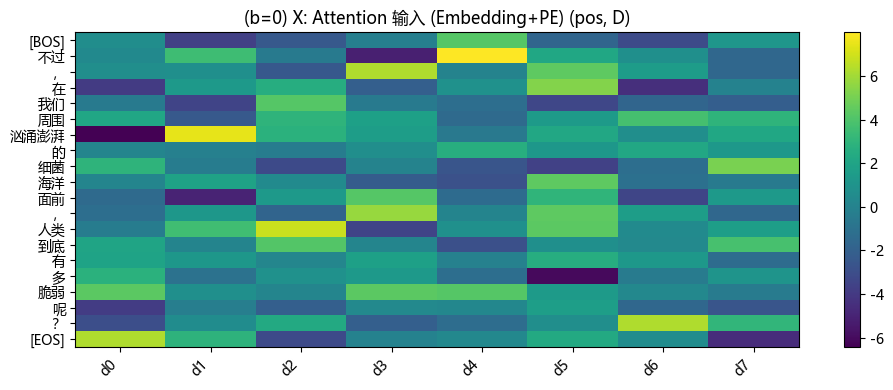

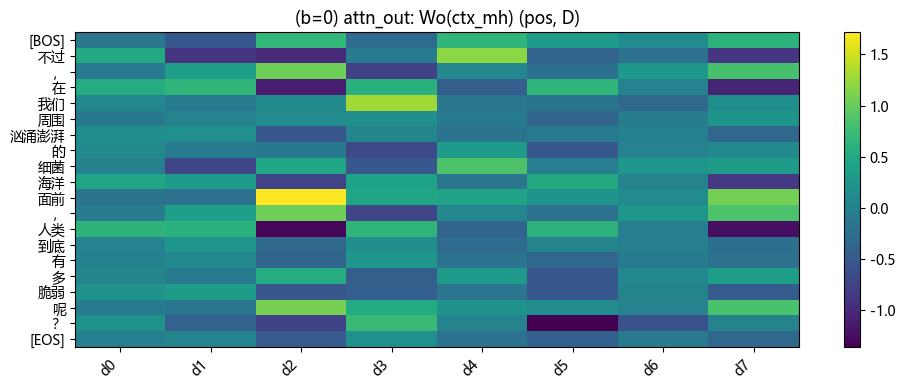

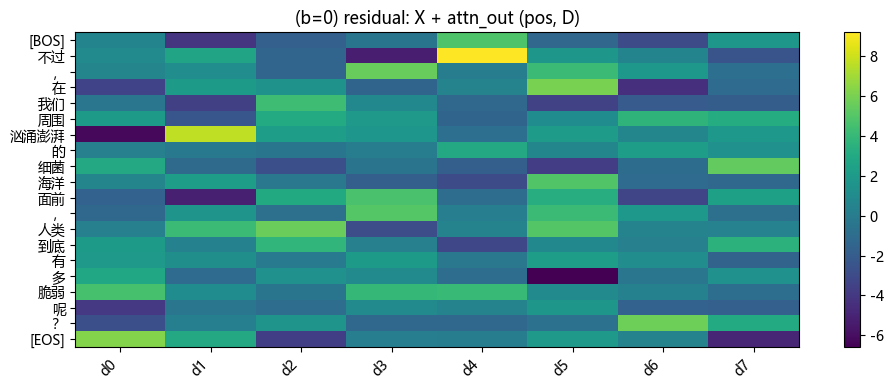

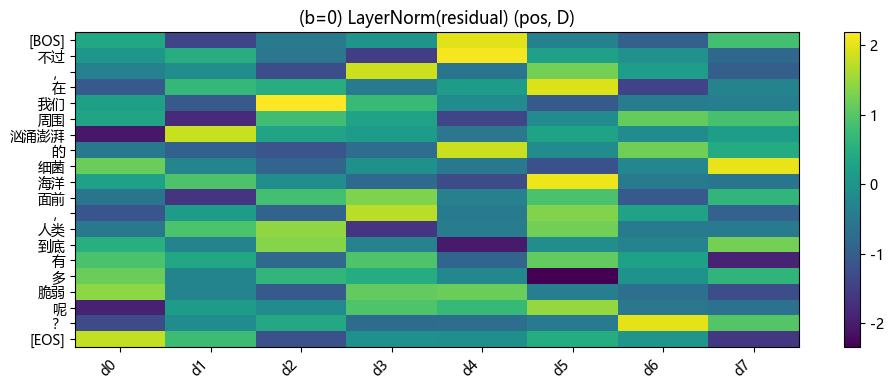


[LayerNorm效果] b=0 前后对比（显示前10个位置）
res mean : [-0.45094907  0.731666    1.3880196  -0.06264248 -0.97517467  1.384126
  1.151119    0.85328895 -0.30777043  0.03125058]
res var  : [ 7.0993853 15.900617   5.040167   9.663454   5.843336   4.322974
 13.027591   1.3390485  8.003191   5.595835 ]
ln  mean : [-2.9802322e-08  4.4703484e-08 -2.2351742e-08 -7.4505806e-09
 -4.8428774e-08  7.4505806e-09 -1.6763806e-08 -1.4901161e-08
  0.0000000e+00  7.4505806e-09]
ln  var  : [0.9999985  0.9999994  0.9999981  0.99999905 0.9999983  0.99999785
 0.99999917 0.9999925  0.99999887 0.99999803]


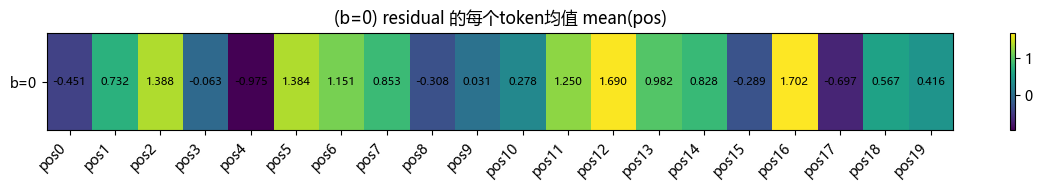

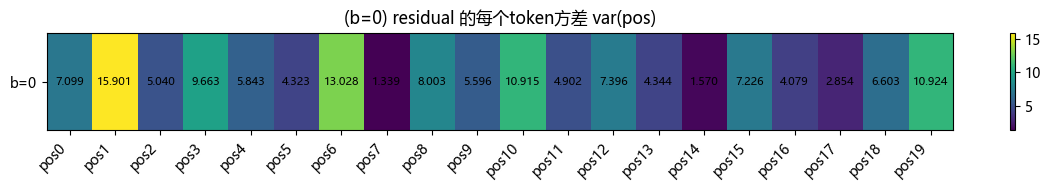

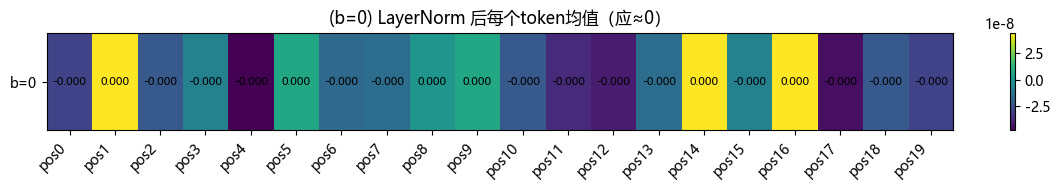

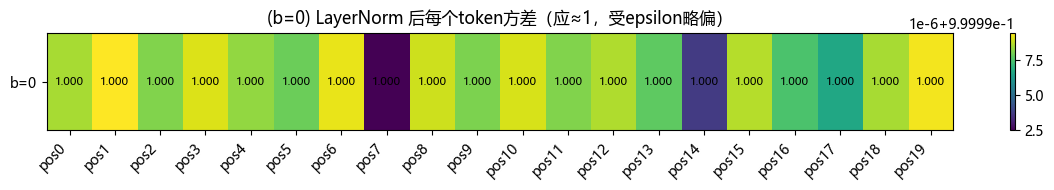

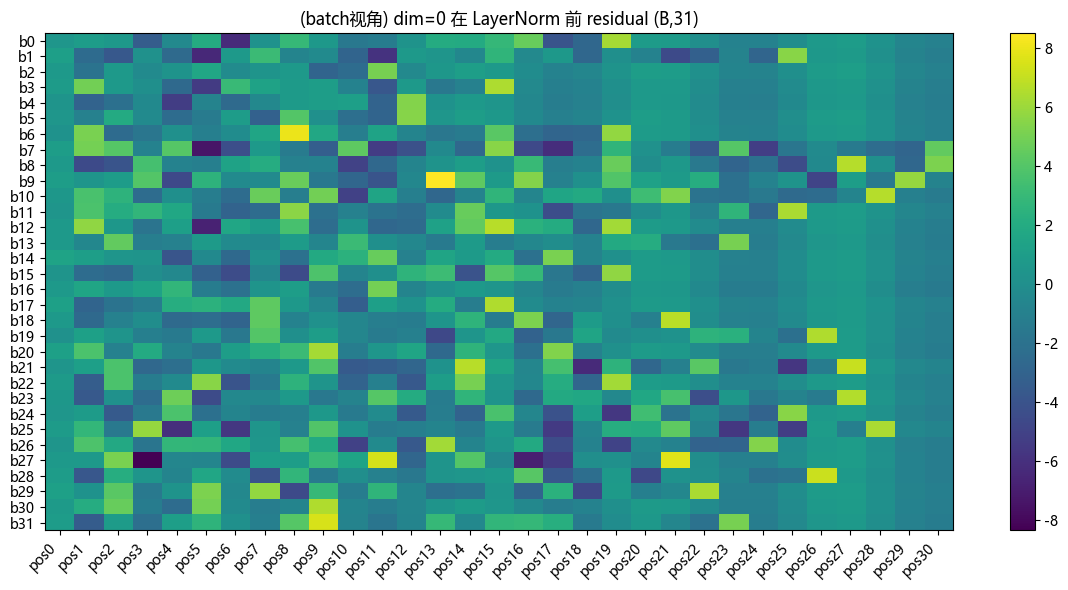

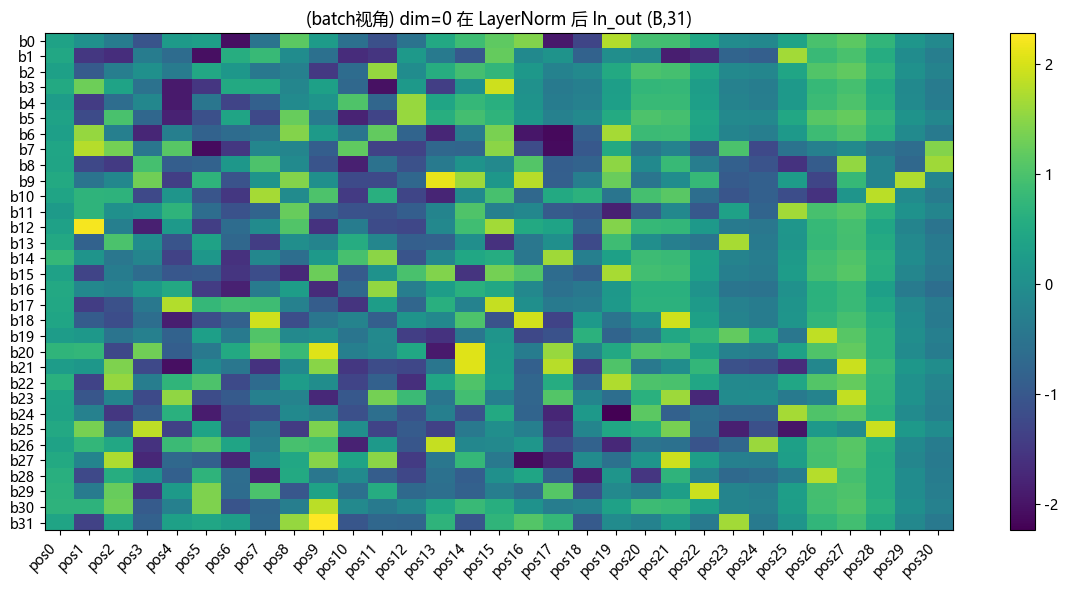

In [35]:
# ====== Cell 11: Wo + Residual + LayerNorm（Encoder Attention 输出块）=====
import torch
import torch.nn as nn

B, S_pad, D = ctx_mh.shape
assert D == d_model

# 1) Wo：把 concat 后的 (B,S,D) 再投影回 (B,S,D)
Wo = nn.Linear(D, D, bias=False).to(DEVICE)

attn_out = Wo(ctx_mh)   # (B,S,D)
print("ctx_mh:", tuple(ctx_mh.shape), "attn_out=Wo(ctx_mh):", tuple(attn_out.shape))

# 2) Residual：加回输入 X（attention 的输入向量）
# X 应该是 src_after_batch (B,S,D)
X = src_after_batch
assert X.shape == attn_out.shape

res = X + attn_out      # (B,S,D)
print("res=X+attn_out:", tuple(res.shape))

# 3) LayerNorm：对最后一维 D 做归一化（每个 token 各自归一化）
ln = nn.LayerNorm(D).to(DEVICE)
ln_out = ln(res)
print("ln_out=LN(res):", tuple(ln_out.shape))

# ====== 单样本可视化：b=0，截到 true_S ======
b = 0
true_S = int((~src_kpm[b]).sum().item())
max_show = min(true_S, 20)

src_tokens_full = [zh_itos[int(i)] for i in src_ids[b].tolist()]
row_labels = src_tokens_full[:max_show]
col_labels = [f"d{j}" for j in range(D)]

X0   = X[b, :max_show].detach().cpu()
O0   = attn_out[b, :max_show].detach().cpu()
R0   = res[b, :max_show].detach().cpu()
LN0  = ln_out[b, :max_show].detach().cpu()

# 先看 attention 输入 X（Embedding+PE）
show_matrix(X0, row_labels=row_labels, col_labels=col_labels,
            title="(b=0) X: Attention 输入 (Embedding+PE) (pos, D)", figsize=(10,4), annotate=False)

# Wo 输出（attention 结果）
show_matrix(O0, row_labels=row_labels, col_labels=col_labels,
            title="(b=0) attn_out: Wo(ctx_mh) (pos, D)", figsize=(10,4), annotate=False)

# 残差结果
show_matrix(R0, row_labels=row_labels, col_labels=col_labels,
            title="(b=0) residual: X + attn_out (pos, D)", figsize=(10,4), annotate=False)

# LayerNorm 输出
show_matrix(LN0, row_labels=row_labels, col_labels=col_labels,
            title="(b=0) LayerNorm(residual) (pos, D)", figsize=(10,4), annotate=False)

# ====== “LN 到底做了什么”：打印每个 token 的均值/方差变化（非常直观）=====
def mean_var_per_token(tensor_BSD):
    # 返回 (B,S) 的 mean 与 var（沿 D 维）
    m = tensor_BSD.mean(dim=-1)
    v = tensor_BSD.var(dim=-1, unbiased=False)
    return m, v

m_res, v_res = mean_var_per_token(res)      # (B,S)
m_ln,  v_ln  = mean_var_per_token(ln_out)   # (B,S)

print("\n[LayerNorm效果] b=0 前后对比（显示前10个位置）")
print("res mean :", m_res[b, :10].detach().cpu().numpy())
print("res var  :", v_res[b, :10].detach().cpu().numpy())
print("ln  mean :", m_ln[b,  :10].detach().cpu().numpy())
print("ln  var  :", v_ln[b,  :10].detach().cpu().numpy())

# 可视化：均值/方差（b=0，前 max_show 个）
show_matrix(m_res[b:b+1, :max_show].detach().cpu(),
            row_labels=[f"b={b}"], col_labels=[f"pos{i}" for i in range(max_show)],
            title="(b=0) residual 的每个token均值 mean(pos)", figsize=(12,2), annotate=True, fmt="{:.3f}")

show_matrix(v_res[b:b+1, :max_show].detach().cpu(),
            row_labels=[f"b={b}"], col_labels=[f"pos{i}" for i in range(max_show)],
            title="(b=0) residual 的每个token方差 var(pos)", figsize=(12,2), annotate=True, fmt="{:.3f}")

show_matrix(m_ln[b:b+1, :max_show].detach().cpu(),
            row_labels=[f"b={b}"], col_labels=[f"pos{i}" for i in range(max_show)],
            title="(b=0) LayerNorm 后每个token均值（应≈0）", figsize=(12,2), annotate=True, fmt="{:.3f}")

show_matrix(v_ln[b:b+1, :max_show].detach().cpu(),
            row_labels=[f"b={b}"], col_labels=[f"pos{i}" for i in range(max_show)],
            title="(b=0) LayerNorm 后每个token方差（应≈1，受epsilon略偏）", figsize=(12,2), annotate=True, fmt="{:.3f}")

# ====== batch 视角：看某一维 dim 的 (B,pos) 在 LN 前后变化 ======
dim = 0
max_col = min(S_pad, 35)
mat_before = res[:, :max_col, dim].detach().cpu()     # (B,pos)
mat_after  = ln_out[:, :max_col, dim].detach().cpu()  # (B,pos)

show_matrix(mat_before,
            row_labels=[f"b{i}" for i in range(B)],
            col_labels=[f"pos{j}" for j in range(max_col)],
            title=f"(batch视角) dim={dim} 在 LayerNorm 前 residual (B,{max_col})",
            figsize=(12,6), annotate=False)

show_matrix(mat_after,
            row_labels=[f"b{i}" for i in range(B)],
            col_labels=[f"pos{j}" for j in range(max_col)],
            title=f"(batch视角) dim={dim} 在 LayerNorm 后 ln_out (B,{max_col})",
            figsize=(12,6), annotate=False)


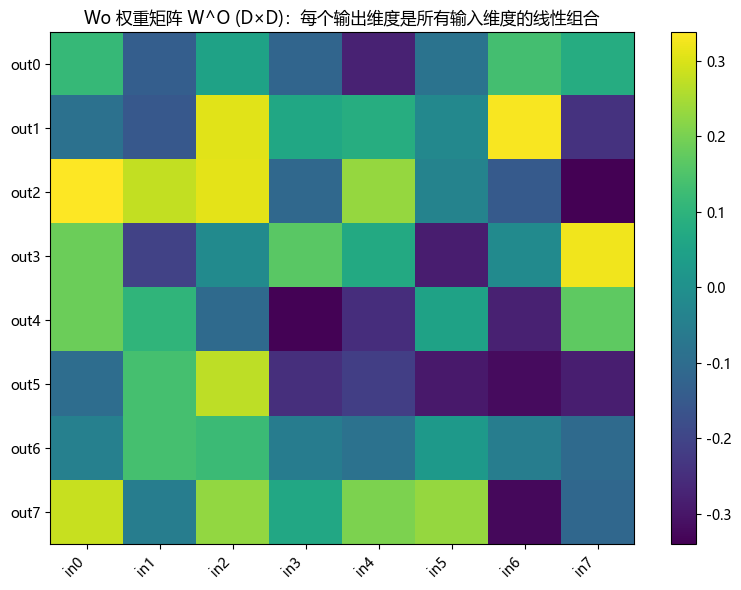

head0 dims: 0.. 3 | head1 dims: 4 .. 7


In [36]:
# Wo.weight: (D, D)   PyTorch里是 out_features x in_features
W = Wo.weight.detach().cpu()  # (D,D)

# 可视化 Wo 权重矩阵
show_matrix(W, 
            row_labels=[f"out{j}" for j in range(D)],
            col_labels=[f"in{j}" for j in range(D)],
            title="Wo 权重矩阵 W^O (D×D)：每个输出维度是所有输入维度的线性组合",
            figsize=(8,6), annotate=False)

# 标出每个head对应的输入维度范围（H=2,d_head=4时：0-3是head0, 4-7是head1）
print("head0 dims: 0..", d_head-1, "| head1 dims:", d_head, "..", 2*d_head-1)


Cell 12：FFN（两层线性 + GELU）+ Residual + LayerNorm（全程可视化）

D = 8 d_ff = 32
Z1=W1(X): (32, 31, 32)
A1=GELU(Z1): (32, 31, 32)
FF=W2(A1): (32, 31, 8)
RES2=X+FF: (32, 31, 8)
Y=LN(RES2): (32, 31, 8)


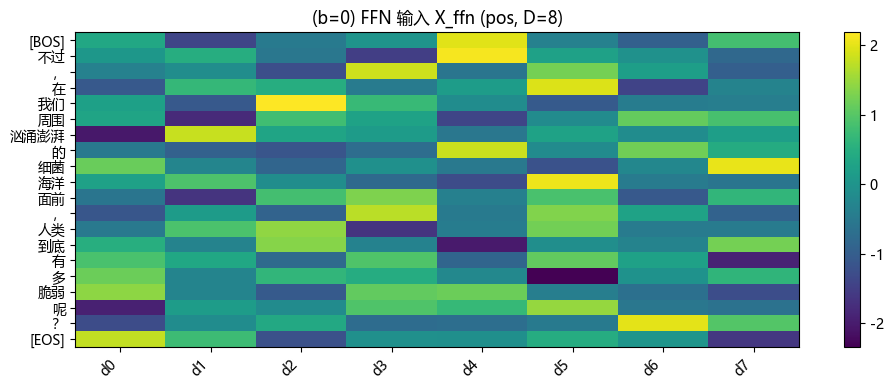

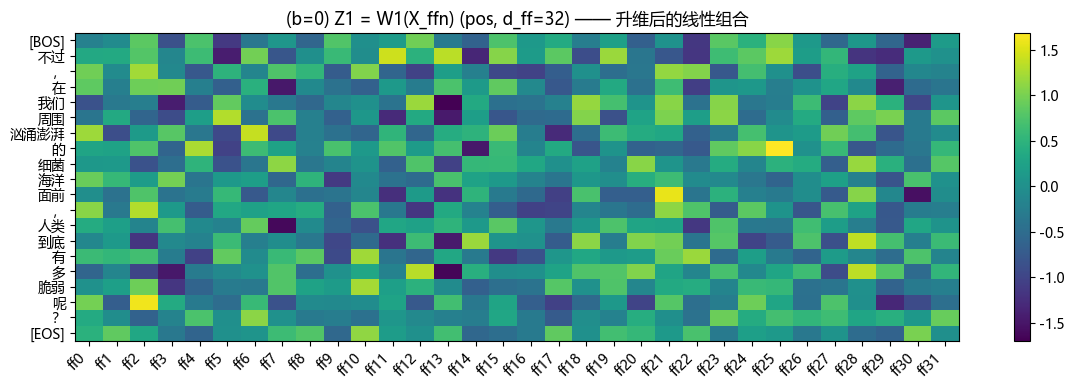

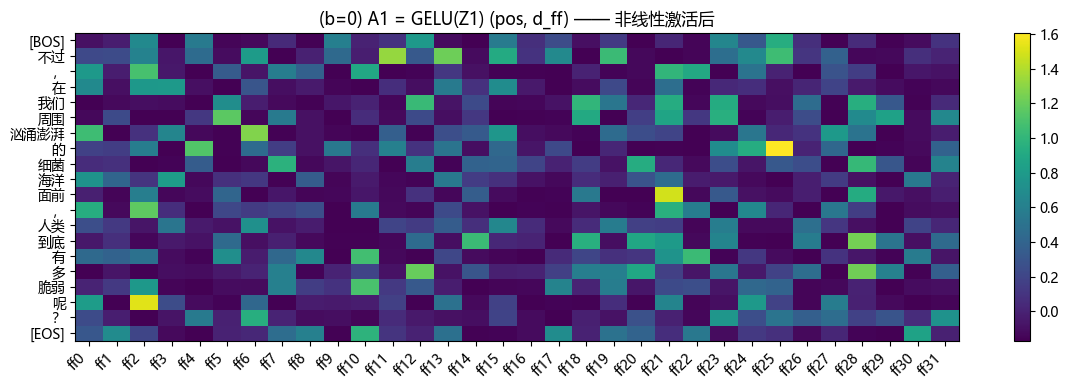

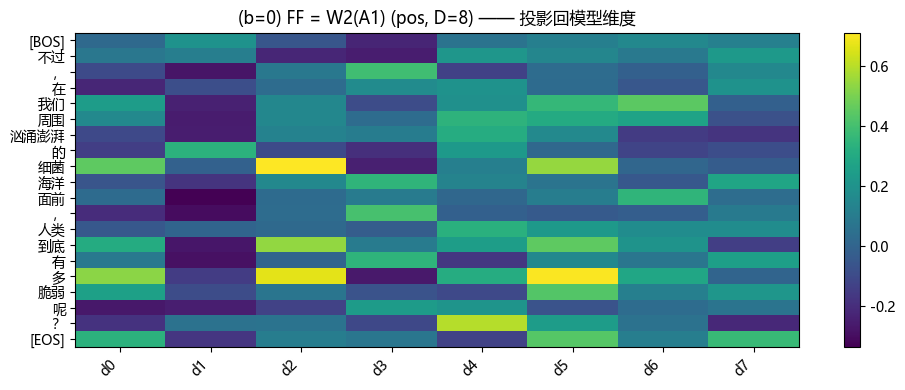

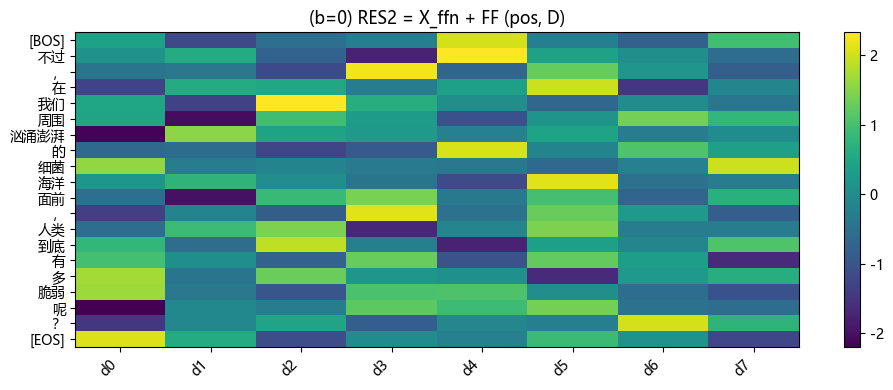

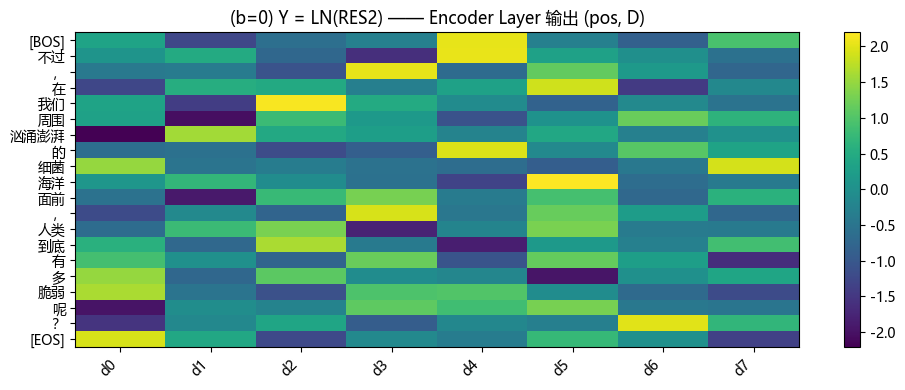


[FFN块 LayerNorm效果] b=0 前后对比（前10个位置）
RES2 mean: [ 0.0474785   0.04768702  0.01616201  0.0331365   0.12981896  0.11439531
  0.00108687 -0.00860981  0.1929883   0.08631285]
RES2 var : [0.9663431  1.2438701  1.1977714  1.0760162  1.0402122  1.1238884
 0.95356715 1.0929337  0.8855161  0.86648947]
Y mean   : [ 7.4505806e-09 -1.4901161e-08  2.2351742e-08 -7.4505806e-09
 -1.4901161e-08 -1.4901161e-08 -1.0593794e-08 -2.2351742e-08
  1.4901161e-08 -1.4901161e-08]
Y var    : [0.99998975 0.99999195 0.99999166 0.9999908  0.9999905  0.9999912
 0.9999895  0.99999076 0.9999886  0.9999883 ]


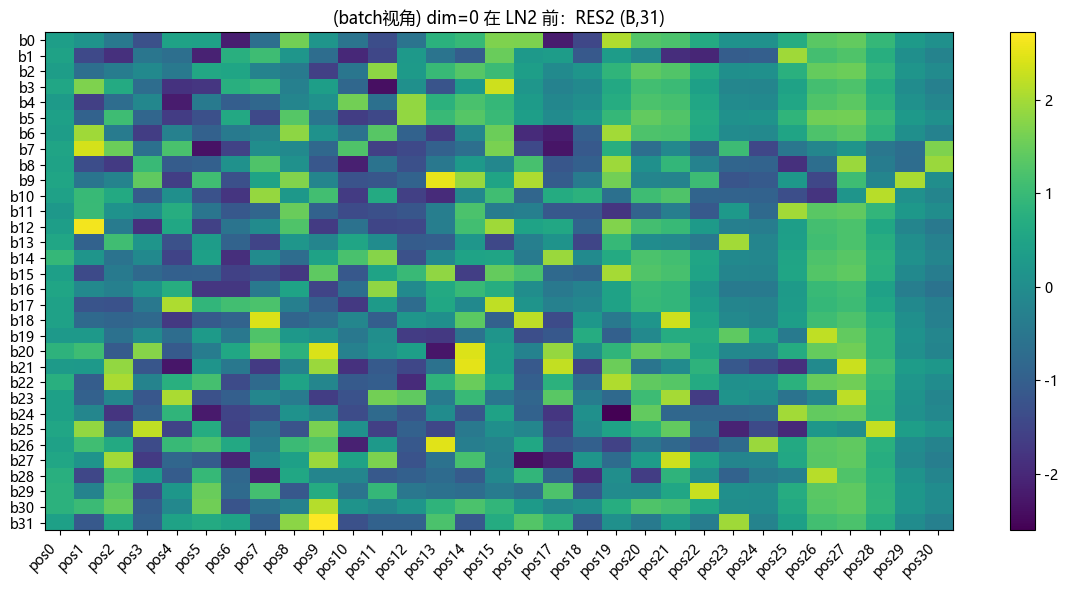

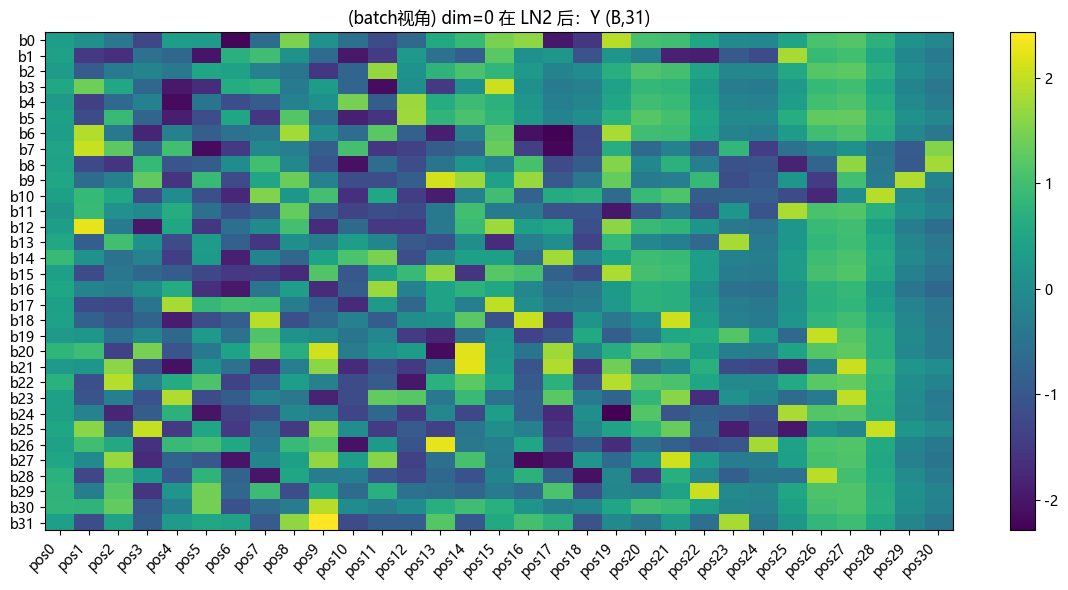

In [37]:
# ====== Cell 12: FFN + Residual + LayerNorm（Encoder Layer 的后半段）=====
import torch
import torch.nn as nn

DEVICE = ln_out.device
B, S_pad, D = ln_out.shape
assert D == d_model == 8

# 1) FFN 的中间维度（你可以调大，比如 32/64，更像论文里的 2048）
d_ff = 32
print("D =", D, "d_ff =", d_ff)

# 2) 定义 FFN：Linear1 -> GELU -> Linear2
W1 = nn.Linear(D, d_ff).to(DEVICE)
W2 = nn.Linear(d_ff, D).to(DEVICE)
act = nn.GELU()

# FFN 输入（来自 attention block 的 LN 输出）
X_ffn = ln_out  # (B,S,D)

# ====== Step A: 线性层1 ======
Z1 = W1(X_ffn)          # (B,S,d_ff)
print("Z1=W1(X):", tuple(Z1.shape))

# ====== Step B: 非线性激活 ======
A1 = act(Z1)            # (B,S,d_ff)
print("A1=GELU(Z1):", tuple(A1.shape))

# ====== Step C: 线性层2（投影回 D） ======
FF = W2(A1)             # (B,S,D)
print("FF=W2(A1):", tuple(FF.shape))

# ====== Step D: Residual ======
RES2 = X_ffn + FF       # (B,S,D)
print("RES2=X+FF:", tuple(RES2.shape))

# ====== Step E: LayerNorm ======
ln2 = nn.LayerNorm(D).to(DEVICE)
Y = ln2(RES2)           # (B,S,D)
print("Y=LN(RES2):", tuple(Y.shape))

# ---------------- 单样本可视化（b=0）----------------
b = 0
true_S = int((~src_kpm[b]).sum().item())
max_show = min(true_S, 20)

src_tokens_full = [zh_itos[int(i)] for i in src_ids[b].tolist()]
rows = src_tokens_full[:max_show]

# 取 b=0 的片段
X0  = X_ffn[b, :max_show].detach().cpu()       # (pos, D)
Z10 = Z1[b, :max_show].detach().cpu()          # (pos, d_ff)
A10 = A1[b, :max_show].detach().cpu()          # (pos, d_ff)
FF0 = FF[b, :max_show].detach().cpu()          # (pos, D)
R20 = RES2[b, :max_show].detach().cpu()        # (pos, D)
Y0  = Y[b, :max_show].detach().cpu()           # (pos, D)

# ① 输入 X_ffn（来自上一块 LN 的输出）
show_matrix(X0, row_labels=rows, col_labels=[f"d{j}" for j in range(D)],
            title="(b=0) FFN 输入 X_ffn (pos, D=8)", figsize=(10,4), annotate=False)

# ② W1 之后升维到 d_ff
show_matrix(Z10, row_labels=rows, col_labels=[f"ff{j}" for j in range(d_ff)],
            title="(b=0) Z1 = W1(X_ffn) (pos, d_ff=32) —— 升维后的线性组合", figsize=(12,4), annotate=False)

# ③ GELU 非线性：会“压扁/保留”不同激活
show_matrix(A10, row_labels=rows, col_labels=[f"ff{j}" for j in range(d_ff)],
            title="(b=0) A1 = GELU(Z1) (pos, d_ff) —— 非线性激活后", figsize=(12,4), annotate=False)

# ④ W2 投影回 D
show_matrix(FF0, row_labels=rows, col_labels=[f"d{j}" for j in range(D)],
            title="(b=0) FF = W2(A1) (pos, D=8) —— 投影回模型维度", figsize=(10,4), annotate=False)

# ⑤ 残差 + LN
show_matrix(R20, row_labels=rows, col_labels=[f"d{j}" for j in range(D)],
            title="(b=0) RES2 = X_ffn + FF (pos, D)", figsize=(10,4), annotate=False)

show_matrix(Y0, row_labels=rows, col_labels=[f"d{j}" for j in range(D)],
            title="(b=0) Y = LN(RES2) —— Encoder Layer 输出 (pos, D)", figsize=(10,4), annotate=False)

# ---------------- LN2 的“均值/方差”对比（超直观）----------------
def mean_var_per_token(t):
    m = t.mean(dim=-1)                 # (B,S)
    v = t.var(dim=-1, unbiased=False)  # (B,S)
    return m, v

m_res2, v_res2 = mean_var_per_token(RES2)
m_y, v_y = mean_var_per_token(Y)

print("\n[FFN块 LayerNorm效果] b=0 前后对比（前10个位置）")
print("RES2 mean:", m_res2[b, :10].detach().cpu().numpy())
print("RES2 var :", v_res2[b, :10].detach().cpu().numpy())
print("Y mean   :", m_y[b, :10].detach().cpu().numpy())
print("Y var    :", v_y[b, :10].detach().cpu().numpy())

# ---------------- Batch 视角：看某一维 dim 在 LN 前后 (B,pos) ----------------
dim = 0
max_col = min(S_pad, 35)
mat_before = RES2[:, :max_col, dim].detach().cpu()  # (B,pos)
mat_after  = Y[:, :max_col, dim].detach().cpu()     # (B,pos)

show_matrix(mat_before,
            row_labels=[f"b{i}" for i in range(B)],
            col_labels=[f"pos{j}" for j in range(max_col)],
            title=f"(batch视角) dim={dim} 在 LN2 前：RES2 (B,{max_col})",
            figsize=(12,6), annotate=False)

show_matrix(mat_after,
            row_labels=[f"b{i}" for i in range(B)],
            col_labels=[f"pos{j}" for j in range(max_col)],
            title=f"(batch视角) dim={dim} 在 LN2 后：Y (B,{max_col})",
            figsize=(12,6), annotate=False)


Cell 13：Decoder Self-Attn（causal）一步一步 + 超直观可视化

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def show_attention_rc(mat, row_labels=None, col_labels=None, title="", figsize=(10,6), annotate=False, fmt="{:.2f}"):
    """
    兼容版 attention 可视化：支持 row_labels/col_labels
    mat: 2D tensor/ndarray
    """
    if torch.is_tensor(mat):
        mat = mat.detach().cpu().numpy()
    mat = np.asarray(mat)

    plt.figure(figsize=figsize)
    plt.imshow(mat, aspect="auto")
    plt.colorbar()
    plt.title(title)

    if row_labels is not None:
        plt.yticks(range(len(row_labels)), row_labels)
    if col_labels is not None:
        plt.xticks(range(len(col_labels)), col_labels, rotation=90)

    if annotate:
        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                plt.text(j, i, fmt.format(mat[i, j]), ha="center", va="center", fontsize=7)

    plt.tight_layout()
    plt.show()


B,S_pad = (32, 47)  B,T_pad = (32, 53)
tgt_inp: (32, 52) tgt_out: (32, 52)
tgt_kpm_inp: (32, 52) causal_inp: (52, 52)
d_model = 8 H = 2 d_head = 4
X_dec (Embedding+PE): (32, 52, 8)
Qh: (32, 2, 52, 4) Kh: (32, 2, 52, 4) Vh: (32, 2, 52, 4)
scores: (32, 2, 52, 52) attn: (32, 2, 52, 52) ctx_h: (32, 2, 52, 4)
ctx_mh: (32, 52, 8) out: (32, 52, 8) Y: (32, 52, 8)

[单样本] b=0 true_T = 26 显示前 20 tokens:
[BOS] since then , his research has focused on using these stem cells to regenerate the critically needed hair cells


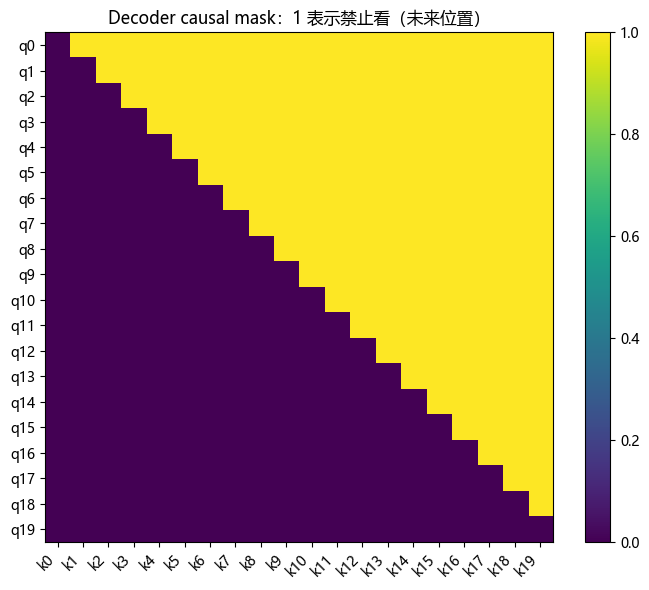

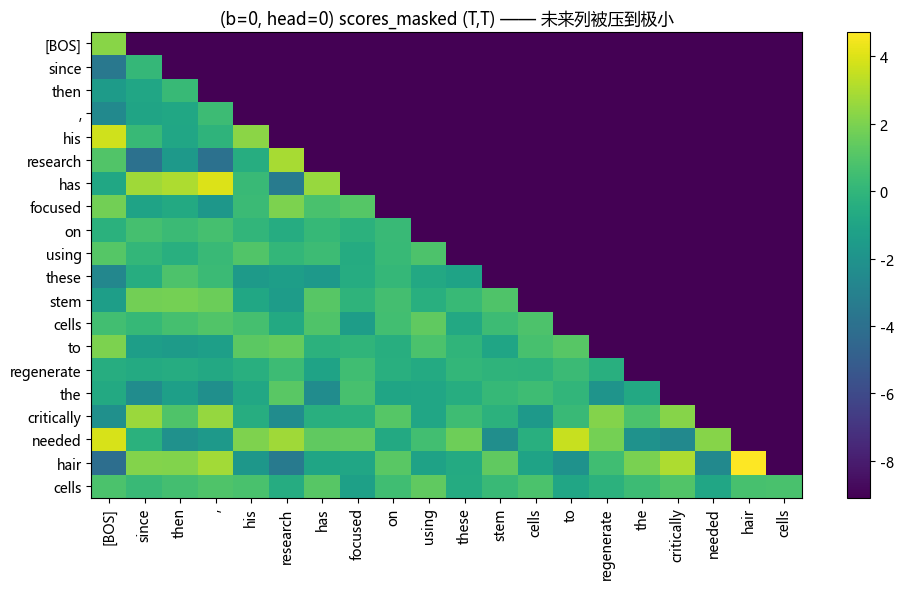

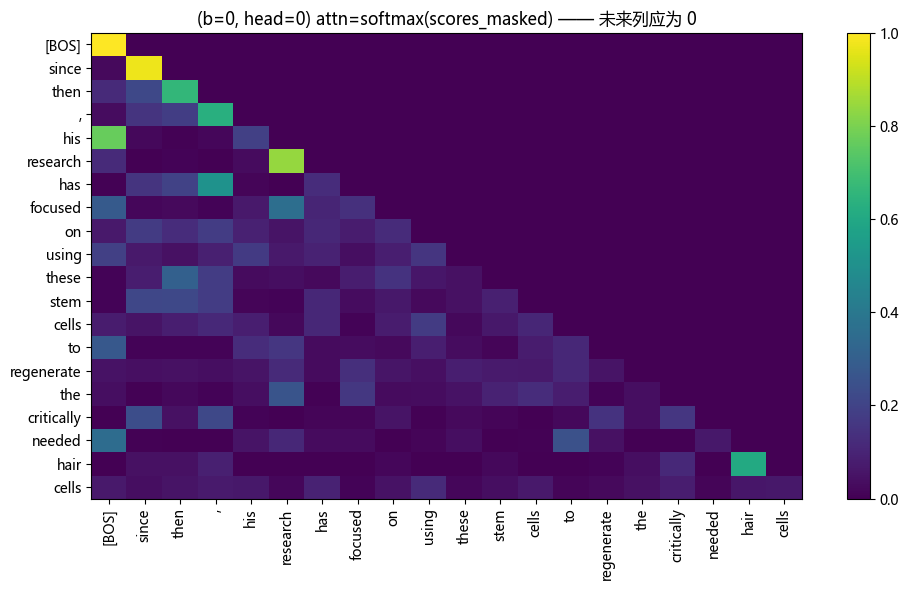


[验证 causal] head=0 | query位置 t=8 token='on' top-attend keys：
  -> key pos  3 token=',' attn=0.1768 ✅
  -> key pos  1 token='since' attn=0.1734 ✅
  -> key pos  2 token='then' attn=0.1263 ✅
  -> key pos  8 token='on' attn=0.1228 ✅
  -> key pos  6 token='has' attn=0.1109 ✅
  -> key pos  4 token='his' attn=0.0914 ✅
  -> key pos  7 token='focused' attn=0.0763 ✅
  -> key pos  0 token='[BOS]' attn=0.0686 ✅
  -> key pos  5 token='research' attn=0.0534 ✅
  -> key pos  9 token='using' attn=0.0000 ❌(未来!)


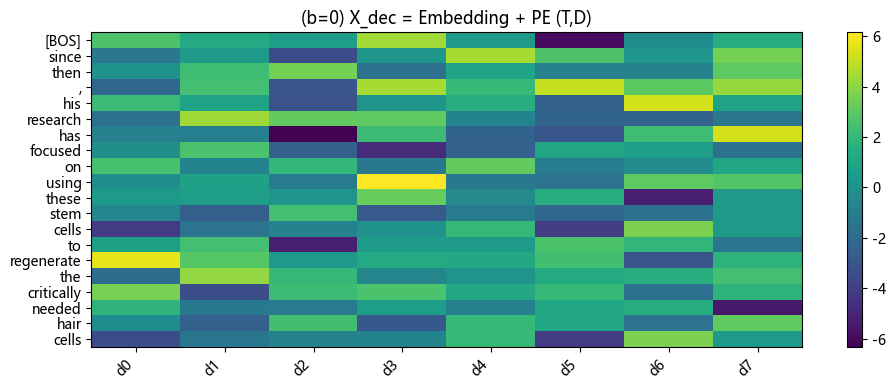

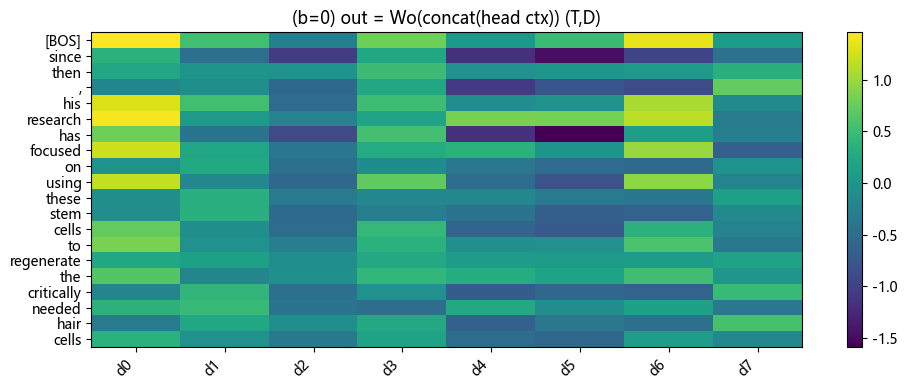

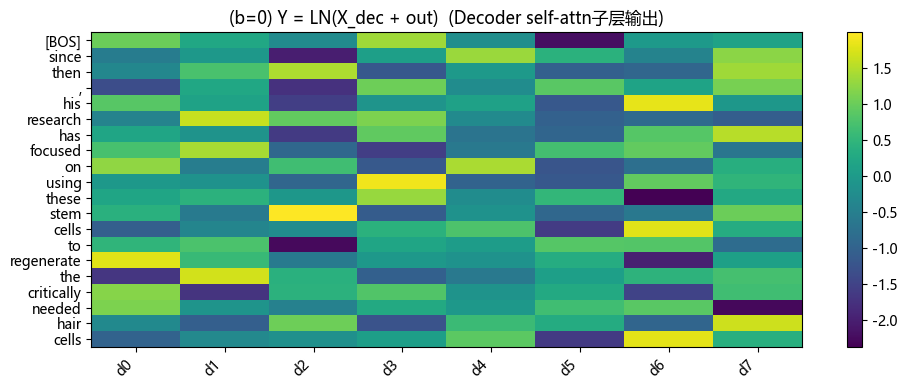

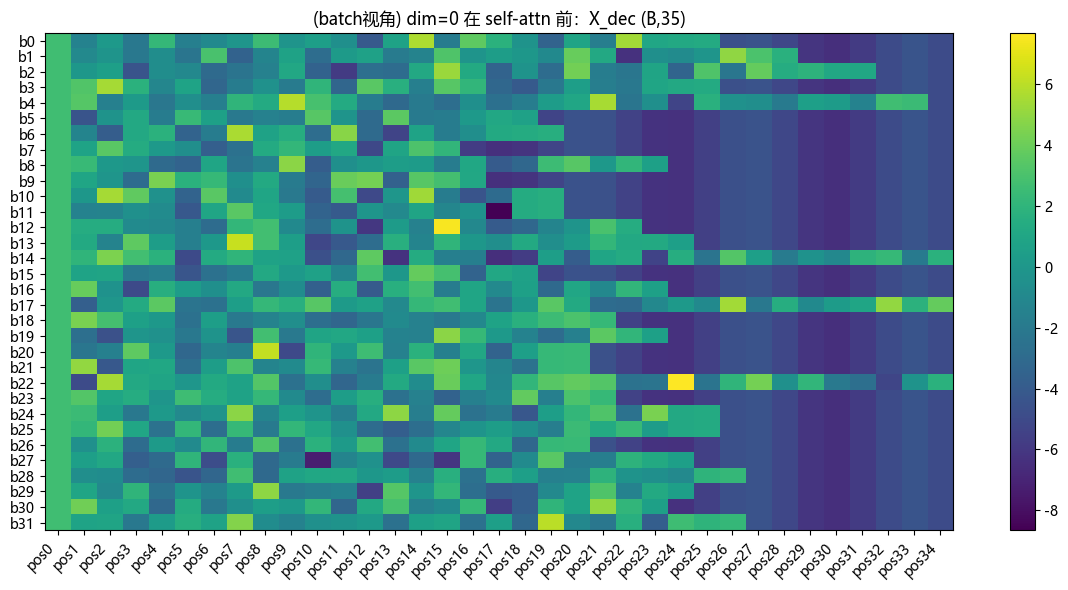

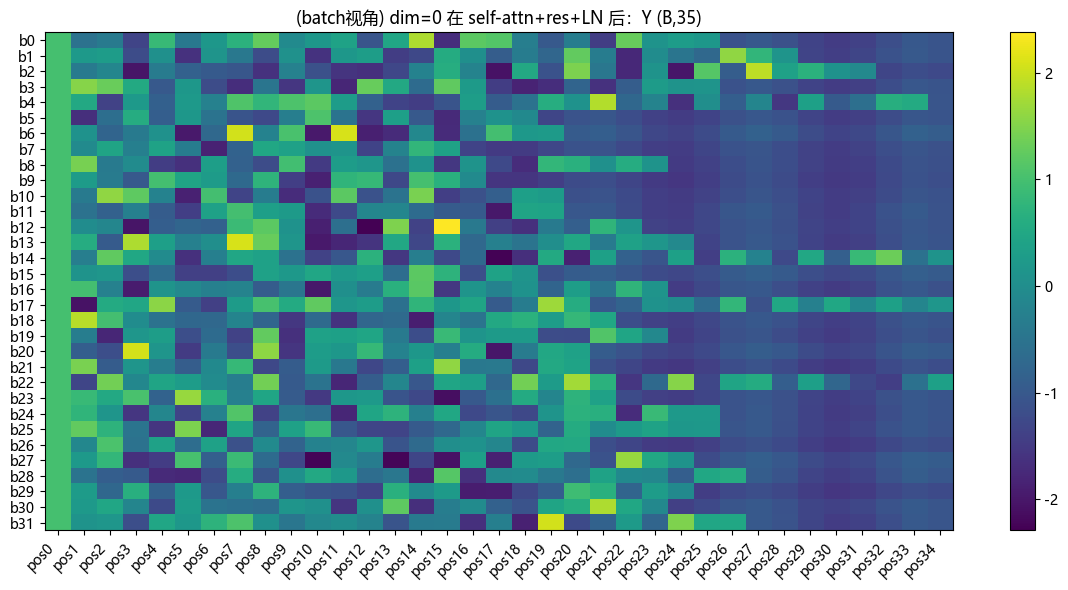

In [42]:
# ====== Cell 13: Decoder Self-Attention with Causal Mask (d_model=8) ======
import torch
import torch.nn as nn
import math

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 取一个 batch（和前面一致）
src_ids, tgt_ids, src_kpm, tgt_kpm, causal, src_texts, tgt_texts = next(iter(train_loader))
src_ids, tgt_ids = src_ids.to(DEVICE), tgt_ids.to(DEVICE)
src_kpm, tgt_kpm = src_kpm.to(DEVICE), tgt_kpm.to(DEVICE)

B, S_pad = src_ids.shape
B2, T_pad = tgt_ids.shape
print("B,S_pad =", (B, S_pad), " B,T_pad =", (B2, T_pad))

# -----------------------------
# (0) Teacher Forcing：decoder 输入右移
# tgt_ids: [BOS, w1, w2, ..., EOS, PAD...]
# tgt_inp: [BOS, w1, ..., w_{T-2}]  预测下一个 token
# tgt_out: [w1, w2, ..., EOS]       训练标签
# -----------------------------
tgt_inp = tgt_ids[:, :-1]                     # (B, T_inp)
tgt_out = tgt_ids[:, 1:]                      # (B, T_inp)
tgt_kpm_inp = (tgt_inp == PAD_ID_EN)          # (B, T_inp)  True=PAD
T_inp = tgt_inp.size(1)

# causal mask 也要匹配 T_inp
causal_inp = make_causal_mask(T_inp).to(DEVICE)  # (T_inp, T_inp) True=不许看未来

print("tgt_inp:", tuple(tgt_inp.shape), "tgt_out:", tuple(tgt_out.shape))
print("tgt_kpm_inp:", tuple(tgt_kpm_inp.shape), "causal_inp:", tuple(causal_inp.shape))

# -----------------------------
# (1) Decoder 输入 embedding + PE
# -----------------------------
d_model = 8
H = 2
assert d_model % H == 0
d_head = d_model // H
print("d_model =", d_model, "H =", H, "d_head =", d_head)

# 复用你之前创建的 tgt_emb（如果不存在就新建一个）
try:
    tgt_emb
except NameError:
    tgt_emb = nn.Embedding(len(en_stoi), d_model).to(DEVICE)

# 复用你的 PE 生成函数
pe = sinusoidal_pe(max_len=max(S_pad, T_pad, T_inp), d_model=d_model, device=DEVICE)  # (max_len, D)

tgt_vec = tgt_emb(tgt_inp) * math.sqrt(d_model)         # (B, T_inp, D)
pe_tgt = pe[:T_inp].unsqueeze(0)                        # (1, T_inp, D)
X_dec = tgt_vec + pe_tgt                                # (B, T_inp, D)
print("X_dec (Embedding+PE):", tuple(X_dec.shape))

# -----------------------------
# (2) 多头 self-attn：Wq/Wk/Wv
# -----------------------------
Wq = nn.Linear(d_model, d_model, bias=False).to(DEVICE)
Wk = nn.Linear(d_model, d_model, bias=False).to(DEVICE)
Wv = nn.Linear(d_model, d_model, bias=False).to(DEVICE)
Wo = nn.Linear(d_model, d_model, bias=False).to(DEVICE)
LN = nn.LayerNorm(d_model).to(DEVICE)

Q = Wq(X_dec)  # (B,T,D)
K = Wk(X_dec)
V = Wv(X_dec)

def split_heads(x, H):
    B, T, D = x.shape
    dh = D // H
    return x.view(B, T, H, dh).permute(0, 2, 1, 3).contiguous()  # (B,H,T,dh)

def combine_heads(x):
    B, H, T, dh = x.shape
    return x.permute(0, 2, 1, 3).contiguous().view(B, T, H * dh)  # (B,T,D)

Qh = split_heads(Q, H)  # (B,H,T,dh)
Kh = split_heads(K, H)
Vh = split_heads(V, H)
print("Qh:", tuple(Qh.shape), "Kh:", tuple(Kh.shape), "Vh:", tuple(Vh.shape))

# scores: (B,H,T,T)
scores = torch.matmul(Qh, Kh.transpose(-2, -1)) / math.sqrt(d_head)

# -----------------------------
# (3) mask：causal + padding（Key列）
# causal_inp: (T,T) True=不许看未来
# tgt_kpm_inp: (B,T) True=PAD
# -----------------------------
scores_masked = scores.masked_fill(causal_inp[None, None, :, :], float("-inf")) \
                      .masked_fill(tgt_kpm_inp[:, None, None, :], float("-inf"))

attn = torch.softmax(scores_masked, dim=-1)
attn = torch.nan_to_num(attn, nan=0.0)  # 防御：极端情况下避免NaN

ctx_h = torch.matmul(attn, Vh)          # (B,H,T,dh)
ctx_mh = combine_heads(ctx_h)           # (B,T,D)
out = Wo(ctx_mh)                        # (B,T,D)

# Residual + LN（decoder self-attn 子层输出）
Y = LN(X_dec + out)                     # (B,T,D)

print("scores:", tuple(scores.shape), "attn:", tuple(attn.shape), "ctx_h:", tuple(ctx_h.shape))
print("ctx_mh:", tuple(ctx_mh.shape), "out:", tuple(out.shape), "Y:", tuple(Y.shape))

# ============================================================
# (4) 超直观可视化：单样本 b=0
# ============================================================
b = 0
# 取 token 标签（英文）
tgt_tokens_full = [en_itos[int(i)] for i in tgt_inp[b].detach().cpu().tolist()]

# true_T：截到非PAD
true_T = int((~tgt_kpm_inp[b]).sum().item())
max_show = min(true_T, 20)

print("\n[单样本] b=0 true_T =", true_T, "显示前", max_show, "tokens:")
print(" ".join(tgt_tokens_full[:max_show]))

# (4.1) 先把 causal mask 画出来（越直观越好）
show_matrix(causal_inp[:max_show, :max_show].float().detach().cpu(),
            row_labels=[f"q{i}" for i in range(max_show)],
            col_labels=[f"k{i}" for i in range(max_show)],
            title="Decoder causal mask：1 表示禁止看（未来位置）",
            figsize=(7,6), annotate=False)

# (4.2) 再画一个 head 的 scores 和 attn（带 token 标签）
h = 0
scores_vis = scores_masked[b, h, :max_show, :max_show].detach().cpu().clone()
if torch.isinf(scores_vis).any():
    finite_min = scores_vis[~torch.isinf(scores_vis)].min()
    scores_vis[torch.isinf(scores_vis)] = finite_min - 5.0

show_attention_rc(scores_vis,
               row_labels=tgt_tokens_full[:max_show],
               col_labels=tgt_tokens_full[:max_show],
               title=f"(b=0, head={h}) scores_masked (T,T) —— 未来列被压到极小",
               figsize=(10,6), annotate=False)

show_attention_rc(attn[b, h, :max_show, :max_show].detach().cpu(),
               row_labels=tgt_tokens_full[:max_show],
               col_labels=tgt_tokens_full[:max_show],
               title=f"(b=0, head={h}) attn=softmax(scores_masked) —— 未来列应为 0",
               figsize=(10,6), annotate=False)

# (4.3) “证据级验证”：挑一个 query 位置 t，打印它 top-attend 的 key，确保 key<=t
t = min(8, max_show-1)  # 你可以改
w = attn[b, h, t, :true_T].detach().cpu()
vals, idx = torch.topk(w, k=min(10, true_T))
print(f"\n[验证 causal] head={h} | query位置 t={t} token='{tgt_tokens_full[t]}' top-attend keys：")
for v, j in zip(vals.tolist(), idx.tolist()):
    flag = "✅" if j <= t else "❌(未来!)"
    print(f"  -> key pos {j:>2} token='{tgt_tokens_full[j]}' attn={v:.4f} {flag}")

# (4.4) 可视化：X_dec / out / Y（每步矩阵变化）
show_matrix(X_dec[b, :max_show].detach().cpu(),
            row_labels=tgt_tokens_full[:max_show],
            col_labels=[f"d{j}" for j in range(d_model)],
            title="(b=0) X_dec = Embedding + PE (T,D)",
            figsize=(10,4), annotate=False)

show_matrix(out[b, :max_show].detach().cpu(),
            row_labels=tgt_tokens_full[:max_show],
            col_labels=[f"d{j}" for j in range(d_model)],
            title="(b=0) out = Wo(concat(head ctx)) (T,D)",
            figsize=(10,4), annotate=False)

show_matrix(Y[b, :max_show].detach().cpu(),
            row_labels=tgt_tokens_full[:max_show],
            col_labels=[f"d{j}" for j in range(d_model)],
            title="(b=0) Y = LN(X_dec + out)  (Decoder self-attn子层输出)",
            figsize=(10,4), annotate=False)

# ============================================================
# (5) batch 视角：看 dim=0 在 (B, pos) 上的变化（只看前35列）
# ============================================================
dim = 0
max_col = min(T_inp, 35)
mat_before = X_dec[:, :max_col, dim].detach().cpu()  # (B,pos)
mat_after  = Y[:, :max_col, dim].detach().cpu()      # (B,pos)

show_matrix(mat_before,
            row_labels=[f"b{i}" for i in range(B)],
            col_labels=[f"pos{j}" for j in range(max_col)],
            title=f"(batch视角) dim={dim} 在 self-attn 前：X_dec (B,{max_col})",
            figsize=(12,6), annotate=False)

show_matrix(mat_after,
            row_labels=[f"b{i}" for i in range(B)],
            col_labels=[f"pos{j}" for j in range(max_col)],
            title=f"(batch视角) dim={dim} 在 self-attn+res+LN 后：Y (B,{max_col})",
            figsize=(12,6), annotate=False)
